# Reddit Classification Project

Project Contents:
- Exploratory Data Analysis
- Classification for the subreddit
- Sentiment Analysis of reddit posts

**Time Taken to run the code**
Code takes ~20 minutes to run. Hyperparamter tuning section takes ~8 minutes.

## Importing Libraries

In [0]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter, OrderedDict
import operator

from datetime import datetime
from dateutil import tz

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn_pandas import DataFrameMapper
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

import warnings
warnings.filterwarnings('ignore') #ignore warnings

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Part 1: Data Loading

### (a) Load the provided dataset (reddit_data.json)

In [0]:
data_all = pd.read_json("reddit_data.zip", orient='records', lines=True)
data_all = data_all[["id", "author", "created_utc", "subreddit", "title", "num_comments", "score", "selftext", "url"]]

In [0]:
data_all.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url
0,abcupx,WithGravy,1546300839,gaming,What are some game games to enjoy on a low-end...,31,3,Got a new laptop and want to enjoy some games ...,https://www.reddit.com/r/gaming/comments/abcup...
1,abcuz2,mikebeingfrank,1546300881,pics,"In 1964, an average wage worker had to clock 8...",4,5,,https://i.redd.it/j6rqqthwcp721.jpg
2,abcv1a,[deleted],1546300892,worldnews,"India: Chinese woman, 25, on solo trip to Khaj...",13,23,,https://timesofindia.indiatimes.com/city/agra/...
3,abcv5v,Lucious-Lyon,1546300914,AskReddit,[Serious] American Liberals of Reddit: Without...,76,0,[removed],https://www.reddit.com/r/AskReddit/comments/ab...
4,abcv7f,sandollars,1546300923,worldnews,"According to the Fiji Government, the Australi...",21,13,,http://fijisun.com.fj/2019/01/01/vuniwaqa-prak...


### (b)	Generate your unique subset of the data

**This section was part of the assignment to generate unique subreddits**

In [0]:
# DO NOT CHANGE THE FUNCTION BELOW
def getMySubreddits(data, my_str):
    assert my_str != "", "You must fill in your unique string"
    import random
    subreddits = sorted(data["subreddit"].unique().tolist())
    rng = random.Random(my_str)
    return rng.sample(subreddits, 4)

In [0]:
# Fill in your UofT email in the variable unique_string below
unique_string = "hamdan.mustafa@mail.utoronto.ca" 
my_subreddits = getMySubreddits(data_all, unique_string)
print("My subreddits:", my_subreddits)

My subreddits: ['soccer', 'worldnews', 'AdviceAnimals', 'AskReddit']


In [0]:
data = data_all[data_all["subreddit"].isin(my_subreddits)]

In [0]:
data.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url
2,abcv1a,[deleted],1546300892,worldnews,"India: Chinese woman, 25, on solo trip to Khaj...",13,23,,https://timesofindia.indiatimes.com/city/agra/...
3,abcv5v,Lucious-Lyon,1546300914,AskReddit,[Serious] American Liberals of Reddit: Without...,76,0,[removed],https://www.reddit.com/r/AskReddit/comments/ab...
4,abcv7f,sandollars,1546300923,worldnews,"According to the Fiji Government, the Australi...",21,13,,http://fijisun.com.fj/2019/01/01/vuniwaqa-prak...
19,abcwbj,[deleted],1546301123,AdviceAnimals,My wife is adamant about not getting pregnant ...,23,59,[deleted],https://i.redd.it/0qqeukfcdp721.jpg
26,abcwzf,[deleted],1546301245,soccer,Is the winter transfer window officially open?,0,1,[removed],https://www.reddit.com/r/soccer/comments/abcwz...


In [0]:
print("# rows:", data.shape[0])
print("# columns:", data.shape[1])

# rows: 43365
# columns: 9


## Part 2: Exploratory Data Analysis 

Each column is explored in this section

### Column 1- Unique Identifier

In [0]:
print("Unique IDs:", data.id.nunique())

Unique IDs: 43365


id is the unique identifier of the post. With a quick check above, it can be seen that it is equal to the number of rows in the data ensuring there are no duplicate posts.

### Column 2- Author

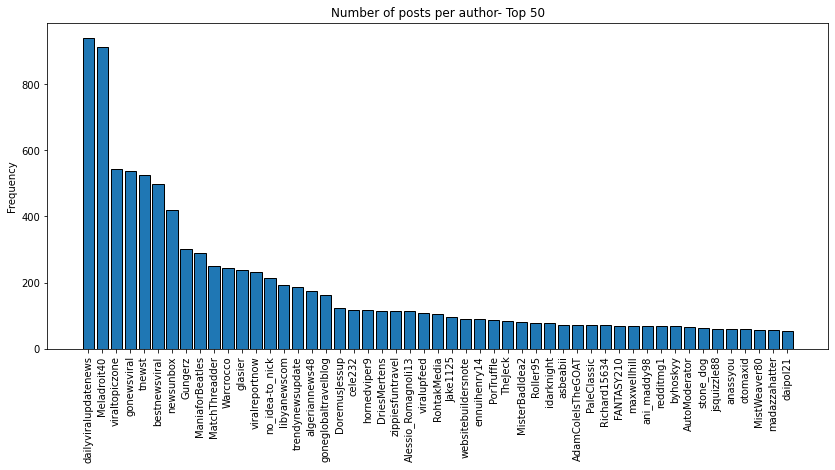

In [0]:
authors_dict= dict(data.author.value_counts()[1:52]) #top author is [deleted] which is not useful information
x= authors_dict.keys()
y= authors_dict.values()

plt.figure(figsize=(14,6))
plt.bar(x,y, edgecolor= 'black')
plt.ylabel('Frequency')
plt.title('Number of posts per author- Top 50')
plt.xticks(rotation= 90)
plt.show()

In [0]:
print("# authors:", data.author.nunique())
print('# of posts by [deleted]: {} ({:0.1f}%)'.format(data.author.value_counts()[0], (data.author.value_counts()[0]/sum(data.author.value_counts())*100)))
print('# of posts by Top 50 authors: {} ({:0.1f}%)'.format(sum(data.author.value_counts()[1:52]), (sum(data.author.value_counts()[1:52])/sum(data.author.value_counts())*100)))
print('# of posts by the other authors not in Top 50: {} ({:0.1f}%)'.format(sum(data.author.value_counts()[53:]), (sum(data.author.value_counts()[53:])/sum(data.author.value_counts())*100)))

# authors: 13483
# of posts by [deleted]: 7654 (17.7%)
# of posts by Top 50 authors: 9564 (22.1%)
# of posts by the other authors not in Top 50: 26092 (60.2%)


Out of the 13,483 authors; there are very few (20 or so) with more than 200 posts. The top 50 authors amount for upto 22% of the entire posts. This indicates that the data is biased by a small percentage of the total authors. 


Note: [deleted] does not mean it is the same author for each of those posts but it is assumed that there is no information available for that.

### Column 3- UTC timestamp

The Unix Timestamp is defined as the number of seconds since Jan 01 1970. Let's convert this column to date for better understanding

In [0]:
data["datetime"]= [datetime.utcfromtimestamp(u).strftime('%Y-%m-%d %H:%M:%S') for u in data.created_utc]

In [0]:
print("Data is from {} to {}" .format(data.datetime.min(), data.datetime.max()))

Data is from 2019-01-01 00:01:32 to 2019-01-31 23:59:38


### Column 4- Subreddit

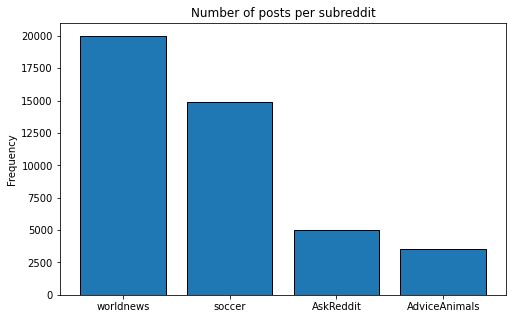

In [0]:
subreddit_dict= dict(data.subreddit.value_counts())
x= subreddit_dict.keys()
y= subreddit_dict.values()

plt.figure(figsize=(8,5))
plt.bar(x,y, edgecolor= 'black')
plt.ylabel('Frequency')
plt.title('Number of posts per subreddit')
plt.show()

worldnews and soccer have more than 15,000 posts whereas AskReddit and AdviceAnimals have less than 5,000 posts. This suggests an imbalanced dataset.

Lets see what the top 50 authors are posting about

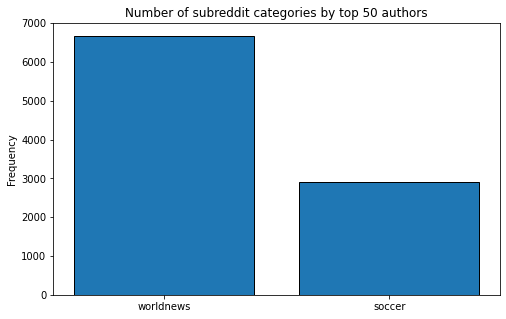

In [0]:
top50_authors_list= list(authors_dict.keys())

data_top50_authors= data[data.author.isin(top50_authors_list)]

x= Counter(data_top50_authors.subreddit).keys()
y= Counter(data_top50_authors.subreddit).values()

plt.figure(figsize=(8,5))
plt.bar(x,y, edgecolor= 'black')
plt.ylabel('Frequency')
plt.title('Number of subreddit categories by top 50 authors')
plt.show()

This indicates that the top 50 authors (22%) of the entire data are posting about only these two subreddits.

### Column 5- Title

Lets clean the title column. This function below is created to do cleaning of the text.

This ensures all the text is lowercase, removes https/www (in case of the url column to be seen later). It removes punctuations and all the stopwords. dollar and star were not removed in this case since they could potentially be useful in understanding what the term is about; there is a difference between 25 and $25.

In [0]:
def TextCleaning (df_preprocessing, column):
    """This function is used to clean the title and URL column"""
    
    #Step 1- Lower case all the text
    df_preprocessing.loc[:,'text_lower'] = df_preprocessing[column].apply(lambda x: x.lower()).copy()
    
    #Step 2- Remove hastags, urls and mentions
    df_preprocessing.loc[:,'text_lower_without_hastags_mentions_urls']=df_preprocessing["text_lower"].apply(lambda x:re.sub('(@[\w]+)|(^rt\s+)|(http[s]:\/\/+[\s]*)|(http:\/\/+[\s]*)|(#)',' ',x))
    
    #Step 3- Remove punctuations
    df_preprocessing.loc[:,'text_lower_without_hastags_mentions_urls_punct']=df_preprocessing["text_lower_without_hastags_mentions_urls"].apply(lambda x:re.sub('([^\w]+)',' ',x))
    
    #Step 4- Remove stopwords                                           
    stop_words=stopwords.words("english")+ ['com', 'www', 'reddit','https', 'r', '1', '2', '0']
    df_preprocessing.loc[:,"text_lower_without_hastags_mentions_urls_punct_stopwords"]=df_preprocessing["text_lower_without_hastags_mentions_urls_punct"].apply(lambda x: str(" ".join(x for x in x.split() if x not in stop_words)))
                                                                                                               
    return df_preprocessing                                                                                                                       

In [0]:
title_clean= TextCleaning(data[["title"]], "title")
title_clean.head()

,title,text_lower,text_lower_without_hastags_mentions_urls,text_lower_without_hastags_mentions_urls_punct,text_lower_without_hastags_mentions_urls_punct_stopwords
2,"India: Chinese woman, 25, on solo trip to Khaj...","india: chinese woman, 25, on solo trip to khaj...","india: chinese woman, 25, on solo trip to khaj...",india chinese woman 25 on solo trip to khajura...,india chinese woman 25 solo trip khajuraho raped
3,[Serious] American Liberals of Reddit: Without...,[serious] american liberals of reddit: without...,[serious] american liberals of reddit: without...,serious american liberals of reddit without a...,serious american liberals without sarcasm one ...
4,"According to the Fiji Government, the Australi...","according to the fiji government, the australi...","according to the fiji government, the australi...",according to the fiji government the australia...,according fiji government australian terrorist...
19,My wife is adamant about not getting pregnant ...,my wife is adamant about not getting pregnant ...,my wife is adamant about not getting pregnant ...,my wife is adamant about not getting pregnant ...,wife adamant getting pregnant masters told use...
26,Is the winter transfer window officially open?,is the winter transfer window officially open?,is the winter transfer window officially open?,is the winter transfer window officially open,winter transfer window officially open


The above table shows the step by step process of how the text cleaning is conducted and the final results.

Now assigning the clean title text to the main data dataframe

In [0]:
data["title_clean"]= title_clean.iloc[:,-1] 
data.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url,datetime,title_clean
2,abcv1a,[deleted],1546300892,worldnews,"India: Chinese woman, 25, on solo trip to Khaj...",13,23,,https://timesofindia.indiatimes.com/city/agra/...,2019-01-01 00:01:32,india chinese woman 25 solo trip khajuraho raped
3,abcv5v,Lucious-Lyon,1546300914,AskReddit,[Serious] American Liberals of Reddit: Without...,76,0,[removed],https://www.reddit.com/r/AskReddit/comments/ab...,2019-01-01 00:01:54,serious american liberals without sarcasm one ...
4,abcv7f,sandollars,1546300923,worldnews,"According to the Fiji Government, the Australi...",21,13,,http://fijisun.com.fj/2019/01/01/vuniwaqa-prak...,2019-01-01 00:02:03,according fiji government australian terrorist...
19,abcwbj,[deleted],1546301123,AdviceAnimals,My wife is adamant about not getting pregnant ...,23,59,[deleted],https://i.redd.it/0qqeukfcdp721.jpg,2019-01-01 00:05:23,wife adamant getting pregnant masters told use...
26,abcwzf,[deleted],1546301245,soccer,Is the winter transfer window officially open?,0,1,[removed],https://www.reddit.com/r/soccer/comments/abcwz...,2019-01-01 00:07:25,winter transfer window officially open


Lets generate wordclouds for each subreddit to understand the key words in each subreddit.

Wordclouds help identify the most frequently used words in the column and this will help us understand the underlying theme in each of the subreddit- something that will complement the activity does in Part 4- Sentiment Analysis.

In [0]:
def convert_text_to_words (post):
    """This function converts sentences into a list of words"""
    words=[]    
    for sentence in post:
        wordList = re.sub("[^\w]", " ",  sentence).split() #converts each post into a list of words (creates a nested list)
        words.append(wordList)
    words= [item for sublist in words for item in sublist] #converts nested list into a 1D list to ease future implementation    
    return words

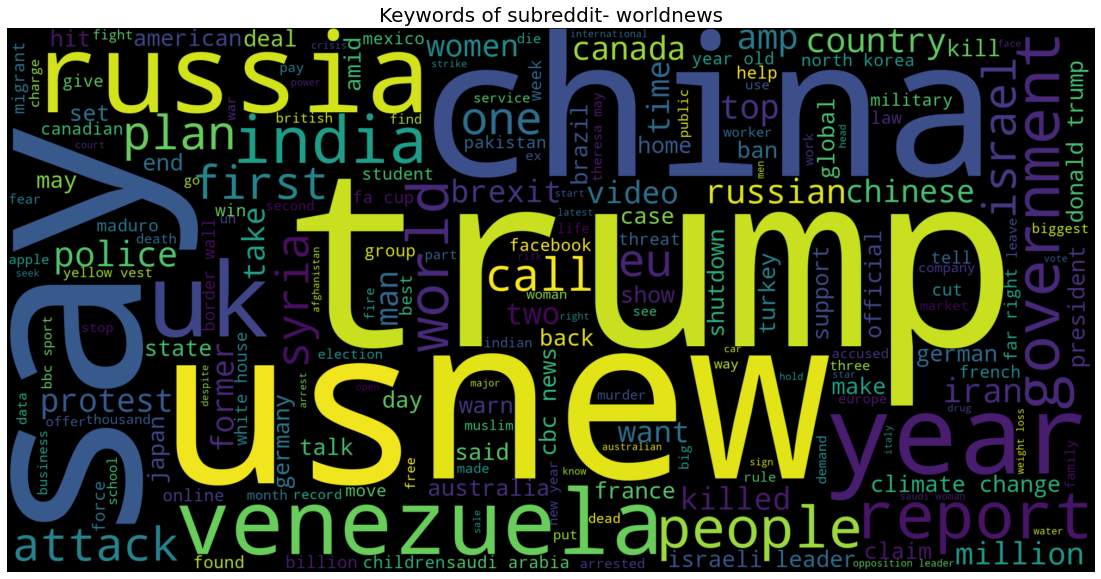

In [0]:
gen= convert_text_to_words(data[data.subreddit== "worldnews"]["title_clean"])
gen_str = ' '.join(gen)
wordcloud = WordCloud(width = 2000, height = 1000).generate(gen_str)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of subreddit- worldnews', fontsize= 20)
plt.axis("off")
plt.show()

worldnews subreddit has key words such as US, Trump, China, Russia which indicate the key terms that could help identify if the post belongs to the worldnews subreddit. There is a wide variety of topics which is expected because worldnews covers the entire activity of the world, however, there are popular themes as it can be seen here with news specially regarding to the US.

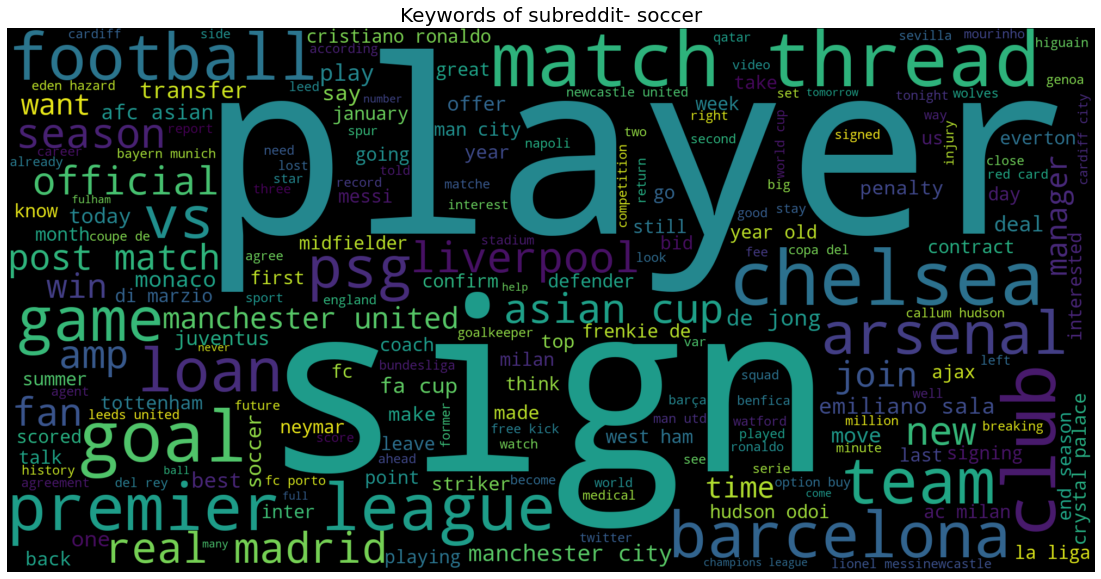

In [0]:
gen= convert_text_to_words(data[data.subreddit== "soccer"]["title_clean"])
gen_str = ' '.join(gen)
wordcloud = WordCloud(width = 2000, height = 1000).generate(gen_str)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of subreddit- soccer', fontsize= 20)
plt.axis("off")
plt.show()

Similar trend with soccer here with terms such as player, sign, goal, Chelsea, Real Madrid. These terms help identify which posts are going to be classified as soccer subreddit. A lot of the word suggests that the subreddit discusses players that will/could be signed by the different clubs; these might not always be true. These terms are also likely to show up in Part 4- Sentiment Analysis.

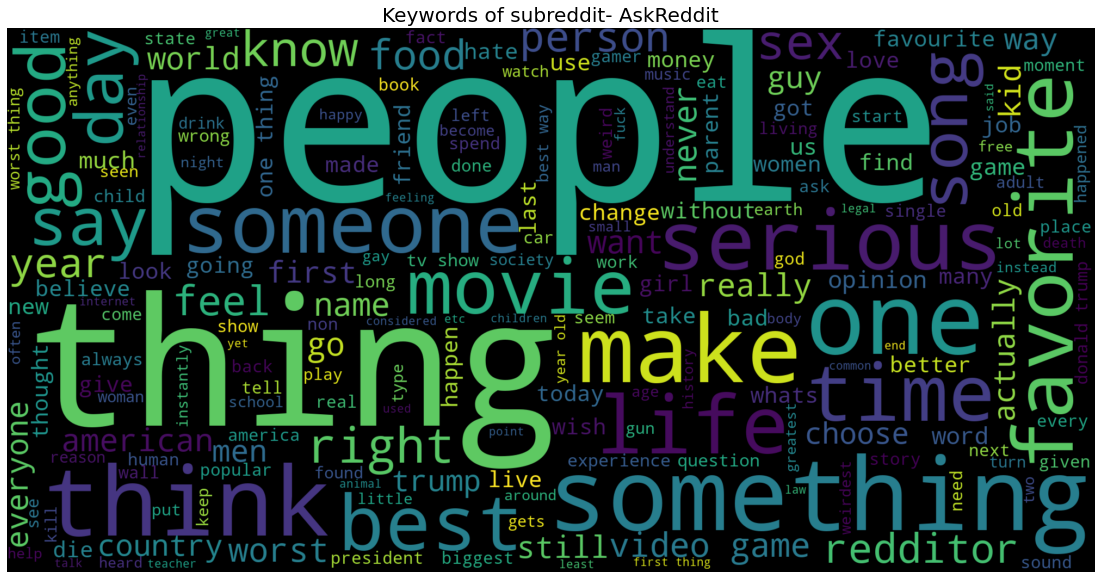

In [0]:
gen= convert_text_to_words(data[data.subreddit== "AskReddit"]["title_clean"])
gen_str = ' '.join(gen)
wordcloud = WordCloud(width = 2000, height = 1000).generate(gen_str)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of subreddit- AskReddit', fontsize= 20)
plt.axis("off")
plt.show()

AskReddit is a lot more general and does not follow a specific theme. It has terms like people, things which covers a wide varitey of topics.

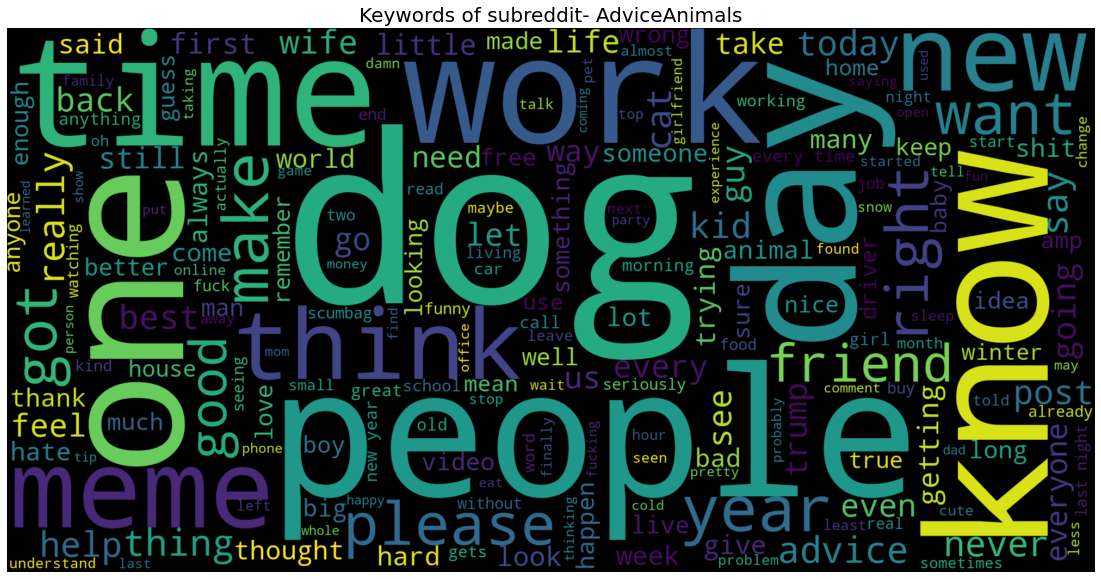

In [0]:
gen= convert_text_to_words(data[data.subreddit== "AdviceAnimals"]["title_clean"])
gen_str = ' '.join(gen)
wordcloud = WordCloud(width = 2000, height = 1000).generate(gen_str)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of subreddit- AdviceAnimals', fontsize= 20)
plt.axis("off")
plt.show()

AdviceAnimals has terms like dog, meme but it also seems a lot more general with terms like people, work, etc. It could potentially get confused with the AskReddit subreddit.

Lets check the wordcloud of the top 50 authors and see what they discuss.

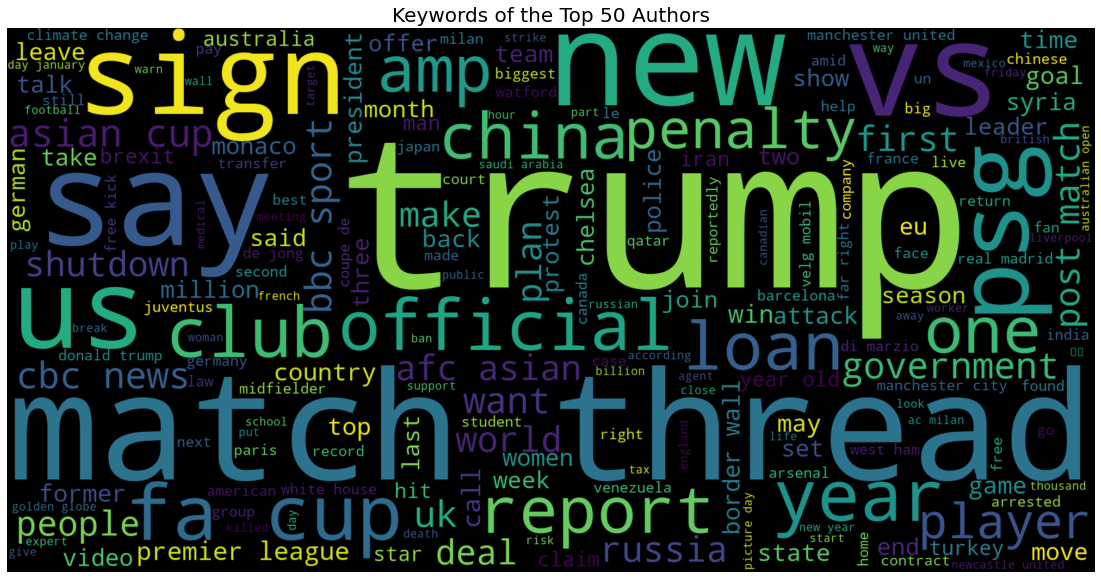

In [0]:
data_top50_authors= data[data.author.isin(top50_authors_list)]
gen= convert_text_to_words(data_top50_authors["title_clean"])
gen_str = ' '.join(gen)
wordcloud = WordCloud(width = 2000, height = 1000).generate(gen_str)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of the Top 50 Authors', fontsize= 20)
plt.axis("off")
plt.show()

As seen in the EDA for subreddit, the top 50 authors only post in worldnews and soccer subreddit and it is visible through the above wordcloud. 

Popular terms like Trump, match, FA Cup, match indicates what is discussed by the top 50 authors.

### Column 6- Number of comments

In [0]:
data.num_comments.describe()

count    43365.000000
mean        66.080364
std        579.277731
min          0.000000
25%          1.000000
50%          3.000000
75%         27.000000
max      37806.000000
Name: num_comments, dtype: float64

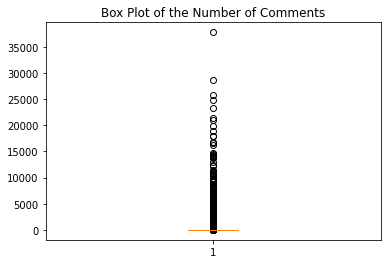

In [0]:
plt.title('Box Plot of the Number of Comments')
plt.boxplot(data.num_comments)
plt.show()

<Figure size 576x576 with 0 Axes>

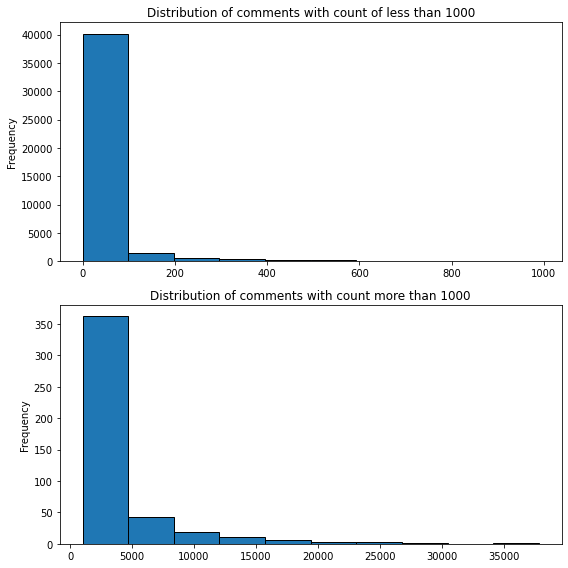

In [0]:
plt.figure(figsize= (8,8))
figure, axes = plt.subplots(2)

figure.set_figheight(8)
figure.set_figwidth(8)
axes[0].hist(data.num_comments[data.num_comments <1000], edgecolor= 'black')
axes[0].set_title("Distribution of comments with count of less than 1000")
axes[0].set_ylabel('Frequency')

axes[1].hist(data.num_comments[data.num_comments >1000], edgecolor= 'black')
axes[1].set_title("Distribution of comments with count more than 1000")
axes[1].set_ylabel('Frequency')

figure.tight_layout()
plt.show()

Most of the posts (around 40,000) have comments less than 100. This shows how the majority of the posts do not have enough comments (are less popular). This column has a lot of outliers as is evident by the boxplot.

### Column 7- Score

In [0]:
data.score.describe()

count     43365.000000
mean        374.298282
std        3525.582852
min           0.000000
25%           1.000000
50%           4.000000
75%          24.000000
max      132996.000000
Name: score, dtype: float64

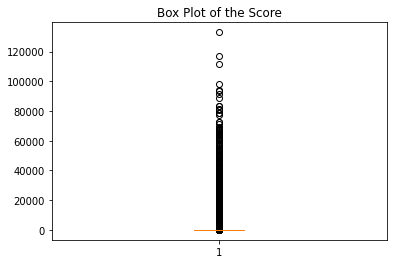

In [0]:
plt.title('Box Plot of the Score')
plt.boxplot(data.score)
plt.show()

<Figure size 576x576 with 0 Axes>

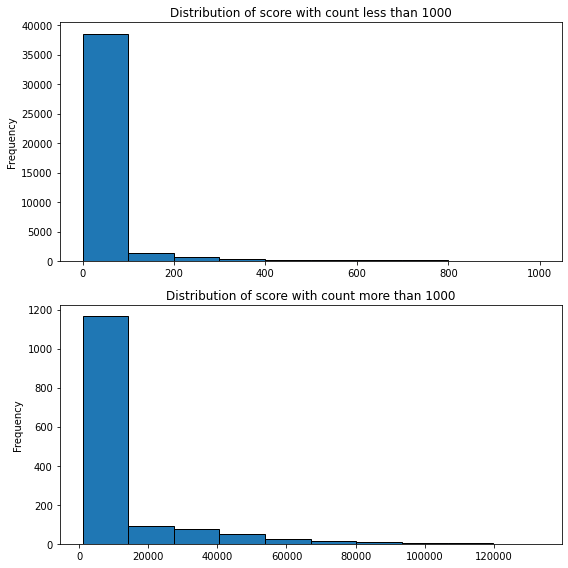

In [0]:
plt.figure(figsize= (8,8))
figure, axes = plt.subplots(2)

figure.set_figheight(8)
figure.set_figwidth(8)
axes[0].hist(data.score[data.score <1000], edgecolor= 'black')
axes[0].set_title("Distribution of score with count less than 1000")
axes[0].set_ylabel('Frequency')

axes[1].hist(data.score[data.score >1000], edgecolor= 'black')
axes[1].set_title("Distribution of score with count more than 1000")
axes[1].set_ylabel('Frequency')

figure.tight_layout()
plt.show()

Similar trend to what was noticed for the number of comments. There are a lot of outliers in this as well.

### Column 8- Body

This column is optional

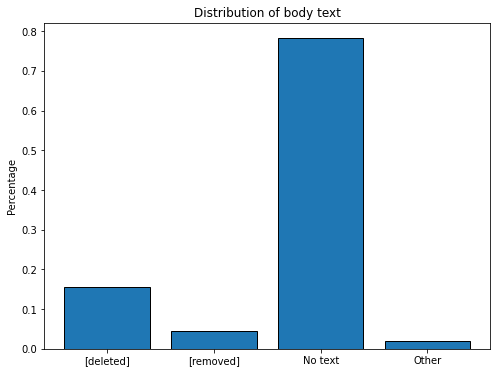

In [0]:
body_dict= dict(data.selftext.value_counts(normalize= True)[:3])
body_dict["No text"] = body_dict.pop("")
body_dict["Other"]= 1-sum(body_dict.values())

x= body_dict.keys()
y= body_dict.values()

plt.figure(figsize=(8,6))
plt.bar(x,y, edgecolor= 'black')
plt.ylabel('Percentage')
plt.title('Distribution of body text')
plt.show()

78% of this column is empty, 19% us either is [deleted] or [removed] and hence this column will not provide any useful information in the grand scheme of things. it will not be used in the Classification

### Column 9- URLs

In [0]:
url_clean= TextCleaning(data[["url"]], "url")

In [0]:
url_clean.head()

,url,text_lower,text_lower_without_hastags_mentions_urls,text_lower_without_hastags_mentions_urls_punct,text_lower_without_hastags_mentions_urls_punct_stopwords
2,https://timesofindia.indiatimes.com/city/agra/...,https://timesofindia.indiatimes.com/city/agra/...,timesofindia.indiatimes.com/city/agra/chinese...,timesofindia indiatimes com city agra chinese...,timesofindia indiatimes city agra chinese woma...
3,https://www.reddit.com/r/AskReddit/comments/ab...,https://www.reddit.com/r/askreddit/comments/ab...,www.reddit.com/r/askreddit/comments/abcv5v/se...,www reddit com r askreddit comments abcv5v se...,askreddit comments abcv5v serious_american_lib...
4,http://fijisun.com.fj/2019/01/01/vuniwaqa-prak...,http://fijisun.com.fj/2019/01/01/vuniwaqa-prak...,fijisun.com.fj/2019/01/01/vuniwaqa-prakash-no...,fijisun com fj 2019 01 01 vuniwaqa prakash no...,fijisun fj 2019 01 01 vuniwaqa prakash fijian ...
19,https://i.redd.it/0qqeukfcdp721.jpg,https://i.redd.it/0qqeukfcdp721.jpg,i.redd.it/0qqeukfcdp721.jpg,i redd it 0qqeukfcdp721 jpg,redd 0qqeukfcdp721 jpg
26,https://www.reddit.com/r/soccer/comments/abcwz...,https://www.reddit.com/r/soccer/comments/abcwz...,www.reddit.com/r/soccer/comments/abcwzf/is_th...,www reddit com r soccer comments abcwzf is_th...,soccer comments abcwzf is_the_winter_transfer_...


In [0]:
data["url_clean"]= url_clean.iloc[:,-1]

As it can be seen above, URL goes through the same cleaning process such as Title. It can be seen that some of the URLs comprise the name of the subreddit itself. This will be investigated further in the next section.

In [0]:
words_askreddit= convert_text_to_words(data[data.subreddit== "AskReddit"]["url_clean"])

In [0]:
print("Number of AskReddit posts:", data[data.subreddit== "AskReddit"]["url_clean"].shape[0])
Counter(words_askreddit).most_common(10)

Number of AskReddit posts: 4999


[('askreddit', 4999),
 ('comments', 4999),
 ('reddit_why_is_donald_j_trump_the_greatest', 4),
 ('how_many_genders_are_there', 3),
 ('men_of_reddit_what_is_the_hardestscariestmost', 3),
 ('what_weird_food_combinations_do_you_really_enjoy', 2),
 ('whats_the_worst_thing_to_say_during_sex', 2),
 ('whats_legal_now_but_probably_wont_be_in_25_years', 2),
 ('whats_your_favorite_word', 2),
 ('what_makes_you_irrationally_angry', 2)]

All the subreddits contain "askreddit" and "comments" in the URL column as suspected. This should give the model an easy way to classify this subreddit when the URL is included.

In [0]:
words_adviceanimals= convert_text_to_words(data[data.subreddit== "AdviceAnimals"]["url_clean"])

In [0]:
print("Number of AskReddit posts:", data[data.subreddit== "AdviceAnimals"]["url_clean"].shape[0])
Counter(words_adviceanimals).most_common(10)

Number of AskReddit posts: 3507


[('jpg', 2098),
 ('redd', 1752),
 ('imgur', 926),
 ('imgflip', 336),
 ('png', 293),
 ('amp', 159),
 ('youtube', 143),
 ('v', 117),
 ('u', 106),
 ('attribution_link', 104)]

In [0]:
list(data[data.subreddit== "AdviceAnimals"]["url"])[:20]

['https://i.redd.it/0qqeukfcdp721.jpg',
 'https://i.redd.it/wo85ott6fp721.jpg',
 'https://i.redd.it/bx2co7jiep721.jpg',
 'https://i.redd.it/430f5lmzhp721.jpg',
 'https://i.redd.it/irdk7w72jp721.jpg',
 'https://imgflip.com/i/2q4x1w',
 'https://imgflip.com/i/2q4zvj',
 'https://i.redd.it/eb7w6eraup721.jpg',
 'https://i.redd.it/49p7jhsmup721.jpg',
 'https://i.redd.it/ng31cg8p1q721.jpg',
 'https://i.redd.it/qujqlcgi4q721.jpg',
 'https://i.redd.it/ls0l5agn4q721.jpg',
 'https://i.redd.it/xs1nzi4u5q721.jpg',
 'https://imgur.com/gallery/U0SqsNh',
 'https://i.imgur.com/RCKG42P.jpg',
 'https://imgflip.com/i/2q572d',
 'https://techorater.blogspot.com/2018/12/best-new-year-wishes-for-2019.html?m=1',
 'https://i.redd.it/ppyrvdczkq721.jpg',
 'http://memedad.com/memes/1485599.jpg',
 'https://imgur.com/c3pgA6F']

For the AdviceAnimals subreddit, the term jpg, img, png is repeated quite frequently. This means that most of the URLs for the AdviceAnimals subreddit are pictures; a lot of them were found to be memes.

The same trend can be noticed for the other two subreddits, but the frequency of specific terms are not as high because they have a lot more posts.

### Importance of the features

Mutual Information is used to understand the importance of the terms in URL and title column in the classification.

In [0]:
def url_dataFrameTransformation(df, k=500):
  url = data['url_clean'].values
  topk = Counter(convert_text_to_words(data["url_clean"])).most_common(k)     
    
  #Find out if a particular url has the word from topk list
  freqReview = []
  for i in range(len(url)):
    tempCounter = Counter([word.lower() for word in re.findall(r'\w+',url[i])])
    topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
    freqReview.append(topkinReview)
  freqReviewDf = pd.DataFrame(freqReview)
  dfName = []
  for c in topk:
    dfName.append(c[0])
  freqReviewDf.columns = dfName

  df_url= data[["subreddit", "url_clean"]].reset_index(drop= True).join(freqReviewDf)
  return topk, df_url

In [0]:
top500_url, df_url= url_dataFrameTransformation(data)

In [0]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='subreddit'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [0]:
getMI(top500_url, df_url)

,Word,MI Score
3,askreddit,0.357045
0,comments,0.299278
10,jpg,0.118343
11,redd,0.095820
7,status,0.090850
...,...,...
481,br,0.000430
411,el,0.000414
493,search,0.000290
468,3d,0.000200


As suspected, the URL column has some important terms that could help with the classification of subreddits and hence it will be used as features for the ML model. Using the URL in the model should help with the AskReddit subreddit classification (because of terms like askreddit and comments). This will be proved later on in the Classification.

In addition, jpg is a term that is quite often found in the AdviceAnimals subreddit and hence it will be help the classification performance of that class too.

In [0]:
def title_dataFrameTransformation(df, k=500):
  title = data['title_clean'].values
  topk = Counter(convert_text_to_words(data["title_clean"])).most_common(k)     
    
  #Find out if a particular url has the word from topk list
  freqReview = []
  for i in range(len(title)):
    tempCounter = Counter([word.lower() for word in re.findall(r'\w+',title[i])])
    topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
    freqReview.append(topkinReview)
  freqReviewDf = pd.DataFrame(freqReview)
  dfName = []
  for c in topk:
    dfName.append(c[0])
  freqReviewDf.columns = dfName
  df_title= data[["subreddit", "title_clean"]].reset_index(drop= True).join(freqReviewDf)
  return topk, df_title

In [0]:
top500_title, df_title= title_dataFrameTransformation(data)

In [0]:
getMI(top500_title, df_title)

,Word,MI Score
0,trump,0.025014
9,match,0.020763
12,league,0.019029
3,vs,0.018210
5,would,0.016567
...,...,...
287,start,0.000038
306,around,0.000034
370,another,0.000033
357,hours,0.000032


The MI score here is less in magnitude than the URL column but that could be because there are a lot more words in title than in URL.

In [0]:
feat_imp = pd.DataFrame()
feat_imp['Feature'] = ["num_comments","score"]
feat_imp['MI'] = mutual_info_classif(data[["num_comments","score"]], LabelEncoder().fit_transform(data['subreddit']))

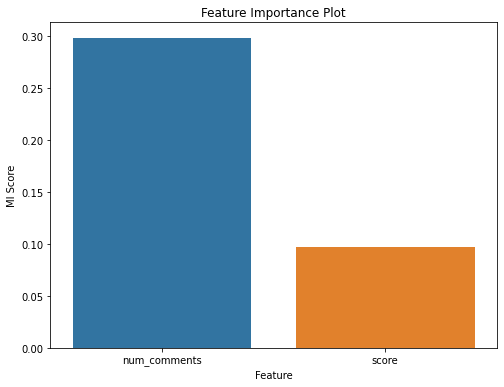

In [0]:
#Plot MI against all features
plt.figure(figsize = (8,6))
ax = sns.barplot(data = feat_imp.reset_index(), x = 'Feature', y = 'MI')
plt.title("Feature Importance Plot")
plt.ylabel("MI Score")
plt.show()

Number of comments seem to have a bigger impact than the score and hence it will be used as part of the features.

### Columns Correlation

In [0]:
data_mod= data.copy()
data_mod['title_clean']= data_mod['title_clean'].astype('category').cat.codes
data_mod['datetime']= data_mod['datetime'].astype('category').cat.codes
data_mod['url_clean']= data_mod['url_clean'].astype('category').cat.codes
data_mod['subreddit']= data_mod['subreddit'].astype('category').cat.codes
data_mod.corr()

,created_utc,subreddit,num_comments,score,datetime,title_clean,url_clean
created_utc,1.000000,-0.007687,-0.004576,-0.000900,0.999717,-0.000800,0.035234
subreddit,-0.007687,1.000000,-0.049749,-0.016026,-0.007829,0.002355,0.193299
num_comments,-0.004576,-0.049749,1.000000,0.637142,-0.004740,0.009068,-0.062525
score,-0.000900,-0.016026,0.637142,1.000000,-0.001043,0.003707,-0.021000
datetime,0.999717,-0.007829,-0.004740,-0.001043,1.000000,-0.000545,0.035486
title_clean,-0.000800,0.002355,0.009068,0.003707,-0.000545,1.000000,-0.031974
url_clean,0.035234,0.193299,-0.062525,-0.021000,0.035486,-0.031974,1.000000


Pearson correlation among the different columns. As expected, num_comments and score have a very strong correlation and hence one of them is redundant. A post with high number of comments is more likely to have a higher score than a post with 2-3 comments.
subreddit seems to have a high correlation with url. Number of comments has a higher correlation when compared to score and hence it will be used in one of the feature sets.

Just as a sanity check, the created_utc has an almost perfect correlation with datetime which makes sense.

## Part 3: Classification

### Workflow
Two types of feature encoding were tried for the Title Column:
1. Boolean vector encoding {0,1}- X1, y1
2. TF IDF- X2, y2

The best amongst the two will be used for three different types of features set:
1. Title- X2, y2
2. Title and URL- X3, y3
3. Title, URL and Number of comments- X4, y4

For the above three models, 5 fold cross-validation is run using the following models:
1. Logistic Regression
2. Naive Bayes
3. SVM

These three models have been used in the course and they are known to do well in NLP tasks. Naive Bayes has diffrent variants, but Multninomial NB is preferred in NLP tasks.

Metrics chosen:
1. Accuracy
2. Precision
3. Recall

Accuracy is a good measure to understand the performance for different models. However, as noticed from the EDA, the dataset is imbalanced and subreddit such as AskReddit and AdviceAnimals have less data. Precision and recall will aid in understanding the comprehensive performance of the model. Precision measures only the rate of false positives. Precision means the percentage of your results which are relevant. Recall refers to the percentage of total relevant results correctly classified by the algorithm.

Confusion matrix will be used to illustrate the results of the best model.

Cross validation (5-fold) is done to understand the robustness of the model and perhaps reduce overfitting.

Hyperparameter tuning will be done for one of the models to achieve the best possible results.

### Boolean Encoding vs TFIDF (using Title data only)

Boolean encoding basically means that if the post contains the word (from the top 500 list), it will be 1, otherwise it is 0.

A popular way to evaluate word frequencies is called TF-IDF. This is an acronym than stands for “Term Frequency – Inverse Document Frequency" which are the components of the resulting scores assigned to each word.

Occurrence count (Count Vectorizer) is anoter approach but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics. To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

##### TFIDF

In [0]:
X1= data['title_clean']
y1= data['subreddit']

The data is split using the train_test_split function as seen below. The data is split into 70% training set and 30% testing set. There is enough data in both sets to run the ML models. In some cases, there is also a validation set used to tune hyperparameters. However, this was not done in this case.

In [0]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state = 42)

In [0]:
#Number of features chosen at random first. This will be optimized later.
tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 1000)

In [0]:
tfidf_train = tfidf_vectorizer.fit_transform(X1_train)
tfidf_test = tfidf_vectorizer.transform(X1_test) # Transform the test data: tfidf_test 

In [0]:
model= LogisticRegression()
model.fit(tfidf_train,y1_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
train_predictions= model.predict(tfidf_train)
test_predictions= model.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y1_train, train_predictions)
accuracy_test= metrics.accuracy_score(y1_test, test_predictions)
print("Train Set Accuracy:", round(accuracy_train,3))
print("Test Set Accuracy:", round(accuracy_test, 3))

print("\nOther Metrics:\n", metrics.classification_report(y1_test, test_predictions))

Train Set Accuracy: 0.814
Test Set Accuracy: 0.799

Other Metrics:
                precision    recall  f1-score   support

AdviceAnimals       0.51      0.20      0.29      1053
    AskReddit       0.69      0.59      0.64      1515
       soccer       0.91      0.85      0.88      4487
    worldnews       0.77      0.92      0.84      5955

     accuracy                           0.80     13010
    macro avg       0.72      0.64      0.66     13010
 weighted avg       0.79      0.80      0.78     13010



#### Boolean Encoding

In [0]:
X2= df_title.iloc[:, 2:]
y2= df_title["subreddit"]

In [0]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state = 42)

In [0]:
model= LogisticRegression()
model.fit(X2_train,y2_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
train_predictions= model.predict(X2_train)
test_predictions= model.predict(X2_test)

accuracy_train = metrics.accuracy_score(y2_train, train_predictions)
accuracy_test= metrics.accuracy_score(y2_test, test_predictions)
print("Train Set Accuracy:", round(accuracy_train,3))
print("Test Set Accuracy:", round(accuracy_test,3))

print("\nOther Metrics:\n", metrics.classification_report(y2_test, test_predictions))

Train Set Accuracy: 0.783
Test Set Accuracy: 0.77

Other Metrics:
                precision    recall  f1-score   support

AdviceAnimals       0.45      0.17      0.25      1053
    AskReddit       0.70      0.59      0.64      1515
       soccer       0.90      0.79      0.84      4487
    worldnews       0.73      0.91      0.81      5955

     accuracy                           0.77     13010
    macro avg       0.69      0.62      0.64     13010
 weighted avg       0.76      0.77      0.75     13010



The two types of encoding gives similar results. However, TFIDF gives slightly better results in terms of accuracy. Plus, there are more parameters that could be used for hyperparameter tuning such as number of features and ngram range (to be done later).

### 5 fold cross-validation using different Models

#### 1- Title data only (X1, y1)

The cross validation function below is used for all the different models and feature sets (had to be modified for the third feature set).

A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. Macro was chosen in this case because it is lower and shows a better representation of the results.

In [0]:
def cross_val(model, Ksplits, X, y):

  kfold = KFold(n_splits=Ksplits)
  kfold.get_n_splits(X)

  train_accuracy= np.zeros(Ksplits)
  test_accuracy = np.zeros(Ksplits)
  precision= np.zeros(Ksplits)
  recall = np.zeros(Ksplits)

  np_idx = 0
  tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 1000)

  for train_idx, test_idx in kfold.split(X):
      X_train, X_test = X.values[train_idx], X.values[test_idx]
      y_train, y_test = y.values[train_idx], y.values[test_idx]

      tfidf_train = tfidf_vectorizer.fit_transform(X_train)
      tfidf_test = tfidf_vectorizer.transform(X_test)
      
      model.fit(tfidf_train, y_train)
      
      train_predictions= model.predict(tfidf_train)
      test_predictions = model.predict(tfidf_test)
      
      train_ACC= metrics.accuracy_score(y_train, train_predictions)*100 
      test_ACC= metrics.accuracy_score(y_test, test_predictions)*100

      prec= metrics.precision_score(y_test, test_predictions, average= "macro")*100 
      rec= metrics.recall_score(y_test, test_predictions, average= "macro")*100

      train_accuracy[np_idx]= train_ACC
      test_accuracy[np_idx] = test_ACC

      precision[np_idx]= prec
      recall[np_idx]= rec 
      np_idx += 1
      
      print ("Fold {}: Train Accuracy= {}%, Test Accuracy= {}%, Precision= {}%, Recall= {}%".format(np_idx, round(train_ACC, 2), round(test_ACC,2), round(prec,2), round(rec,2)))   

  
  print ("\nAverage Train Accuracy= {}% ({}%), Average Test Accuracy= {}% ({}%), Average Precision= {}% ({}%), Average Recall= {}% ({}%)".format(round(np.mean(train_accuracy),2),round(np.std(train_accuracy),2), round(np.mean(test_accuracy),2),round(np.std(test_accuracy),2), round(np.mean(precision),2), round(np.std(precision),2), round(np.mean(recall),2), round(np.std(recall),2)))

  return np.mean(train_accuracy), np.mean(test_accuracy), np.mean(precision), np.mean(recall)

In [0]:
feature1_result1= cross_val(LogisticRegression(), 5, X1, y1)

Fold 1: Train Accuracy= 81.28%, Test Accuracy= 78.27%, Precision= 69.37%, Recall= 62.49%
Fold 2: Train Accuracy= 81.19%, Test Accuracy= 78.99%, Precision= 71.06%, Recall= 63.2%
Fold 3: Train Accuracy= 81.54%, Test Accuracy= 78.19%, Precision= 70.73%, Recall= 62.93%
Fold 4: Train Accuracy= 81.42%, Test Accuracy= 79.85%, Precision= 72.22%, Recall= 63.94%
Fold 5: Train Accuracy= 81.26%, Test Accuracy= 79.81%, Precision= 68.84%, Recall= 62.82%

Average Train Accuracy= 81.34% (0.13%), Average Test Accuracy= 79.02% (0.72%), Average Precision= 70.44% (1.21%), Average Recall= 63.08% (0.49%)


In [0]:
feature1_result2= cross_val(MultinomialNB(), 5, X1, y1)

Fold 1: Train Accuracy= 79.6%, Test Accuracy= 76.4%, Precision= 67.02%, Recall= 59.38%
Fold 2: Train Accuracy= 79.49%, Test Accuracy= 78.21%, Precision= 70.68%, Recall= 61.03%
Fold 3: Train Accuracy= 79.61%, Test Accuracy= 77.02%, Precision= 69.69%, Recall= 60.37%
Fold 4: Train Accuracy= 79.51%, Test Accuracy= 78.42%, Precision= 71.02%, Recall= 60.96%
Fold 5: Train Accuracy= 79.32%, Test Accuracy= 79.08%, Precision= 68.51%, Recall= 60.56%

Average Train Accuracy= 79.51% (0.11%), Average Test Accuracy= 77.83% (0.98%), Average Precision= 69.39% (1.47%), Average Recall= 60.46% (0.59%)


In [0]:
feature1_result3= cross_val(LinearSVC(), 5, X1, y1)

Fold 1: Train Accuracy= 81.43%, Test Accuracy= 78.08%, Precision= 68.49%, Recall= 62.38%
Fold 2: Train Accuracy= 81.39%, Test Accuracy= 78.88%, Precision= 70.44%, Recall= 63.41%
Fold 3: Train Accuracy= 81.71%, Test Accuracy= 78.38%, Precision= 70.96%, Recall= 63.39%
Fold 4: Train Accuracy= 81.53%, Test Accuracy= 79.93%, Precision= 71.83%, Recall= 64.33%
Fold 5: Train Accuracy= 81.36%, Test Accuracy= 79.82%, Precision= 68.32%, Recall= 63.08%

Average Train Accuracy= 81.48% (0.13%), Average Test Accuracy= 79.02% (0.74%), Average Precision= 70.01% (1.38%), Average Recall= 63.32% (0.63%)


As seen from the earlier section, the recall is low because the imbalanced classes are being misclassified as the majority classes (worldnews and soccer).
The three models did similar in most metrics, with Naive Bayes being lower than the other two.

#### 2- Title and URL data (X3, y3)

In [0]:
X3= data['url_clean'] + data['title_clean']
y3= data['subreddit']

In [0]:
feature2_result1= cross_val(LogisticRegression(), 5, X3, y3)

Fold 1: Train Accuracy= 96.01%, Test Accuracy= 94.11%, Precision= 93.35%, Recall= 92.91%
Fold 2: Train Accuracy= 96.04%, Test Accuracy= 94.93%, Precision= 94.18%, Recall= 93.36%
Fold 3: Train Accuracy= 96.1%, Test Accuracy= 95.02%, Precision= 94.26%, Recall= 93.8%
Fold 4: Train Accuracy= 96.09%, Test Accuracy= 95.02%, Precision= 93.78%, Recall= 93.67%
Fold 5: Train Accuracy= 96.02%, Test Accuracy= 95.24%, Precision= 94.92%, Recall= 93.27%

Average Train Accuracy= 96.05% (0.04%), Average Test Accuracy= 94.86% (0.39%), Average Precision= 94.1% (0.52%), Average Recall= 93.4% (0.31%)


In [0]:
feature2_result2= cross_val(MultinomialNB(), 5, X3, y3)

Fold 1: Train Accuracy= 94.32%, Test Accuracy= 92.29%, Precision= 91.4%, Recall= 91.43%
Fold 2: Train Accuracy= 94.31%, Test Accuracy= 93.96%, Precision= 93.14%, Recall= 92.36%
Fold 3: Train Accuracy= 94.3%, Test Accuracy= 93.43%, Precision= 92.6%, Recall= 91.68%
Fold 4: Train Accuracy= 94.34%, Test Accuracy= 93.8%, Precision= 92.19%, Recall= 92.42%
Fold 5: Train Accuracy= 94.31%, Test Accuracy= 93.95%, Precision= 93.01%, Recall= 92.86%

Average Train Accuracy= 94.31% (0.01%), Average Test Accuracy= 93.48% (0.63%), Average Precision= 92.47% (0.63%), Average Recall= 92.15% (0.52%)


In [0]:
feature2_result3= cross_val(LinearSVC(), 5, X3, y3)

Fold 1: Train Accuracy= 96.44%, Test Accuracy= 94.37%, Precision= 93.35%, Recall= 93.52%
Fold 2: Train Accuracy= 96.46%, Test Accuracy= 95.5%, Precision= 94.69%, Recall= 94.21%
Fold 3: Train Accuracy= 96.52%, Test Accuracy= 95.42%, Precision= 94.51%, Recall= 94.47%
Fold 4: Train Accuracy= 96.5%, Test Accuracy= 95.39%, Precision= 93.9%, Recall= 94.56%
Fold 5: Train Accuracy= 96.42%, Test Accuracy= 95.56%, Precision= 94.64%, Recall= 94.14%

Average Train Accuracy= 96.47% (0.04%), Average Test Accuracy= 95.25% (0.44%), Average Precision= 94.22% (0.52%), Average Recall= 94.18% (0.37%)


The three models displayed similar performance again with SVM giving the best results.

#### 3- Title, URL, number of comments data (X4, y4)

To combine TF-IDF features and the comments feature, I used DataFrameMapper.

Source: https://sondosatwi.wordpress.com/2017/08/01/using-text-data-and-dataframemapper-in-python/

In [0]:
mapper = DataFrameMapper([
     ('title_clean', TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 1000)),
     ('url_clean', TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 1000)),
     ('num_comments', None),
     ])

In [0]:
X4 = mapper.fit_transform(data.loc[:,["title_clean", "url_clean", "num_comments"]])
y4= data['subreddit']

In [0]:
def cross_val_mod(model, Ksplits, X, y):

  kfold = KFold(n_splits=Ksplits)
  kfold.get_n_splits(X)

  train_accuracy= np.zeros(Ksplits)
  test_accuracy = np.zeros(Ksplits)
  precision= np.zeros(Ksplits)
  recall = np.zeros(Ksplits)

  np_idx = 0

  for train_idx, test_idx in kfold.split(X):
      X_train, X_test = X.values[train_idx], X.values[test_idx]
      y_train, y_test = y.values[train_idx], y.values[test_idx]
      
      model.fit(X_train, y_train)
      
      train_predictions= model.predict(X_train)
      test_predictions = model.predict(X_test)
      
      train_ACC= metrics.accuracy_score(y_train, train_predictions)*100 
      test_ACC= metrics.accuracy_score(y_test, test_predictions)*100

      prec= metrics.precision_score(y_test, test_predictions, average= "macro")*100
      rec= metrics.recall_score(y_test, test_predictions, average= "macro")*100

      train_accuracy[np_idx]= train_ACC
      test_accuracy[np_idx] = test_ACC

      precision[np_idx]= prec
      recall[np_idx]= rec 
      np_idx += 1
      
      print ("Fold {}: Train Accuracy= {}%, Test Accuracy= {}%, Precision= {}%, Recall= {}%".format(np_idx, round(train_ACC, 2), round(test_ACC,2), round(prec,2), round(rec,2)))   

  print ("\nAverage Train Accuracy= {}% ({}%), Average Test Accuracy= {}% ({}%), Average Precision= {}% ({}%), Average Recall= {}% ({}%)".format(round(np.mean(train_accuracy),2),round(np.std(train_accuracy),2), round(np.mean(test_accuracy),2),round(np.std(test_accuracy),2), round(np.mean(precision),2), round(np.std(precision),2), round(np.mean(recall),2), round(np.std(recall),2)))
  return np.mean(train_accuracy), np.mean(test_accuracy), np.mean(precision), np.mean(recall)

In [0]:
feature3_result1= cross_val_mod(LogisticRegression(),5, pd.DataFrame(X4),y4)

Fold 1: Train Accuracy= 88.04%, Test Accuracy= 87.71%, Precision= 85.63%, Recall= 81.72%
Fold 2: Train Accuracy= 87.82%, Test Accuracy= 87.2%, Precision= 86.28%, Recall= 82.39%
Fold 3: Train Accuracy= 87.6%, Test Accuracy= 86.82%, Precision= 87.52%, Recall= 82.5%
Fold 4: Train Accuracy= 87.84%, Test Accuracy= 88.16%, Precision= 87.77%, Recall= 83.49%
Fold 5: Train Accuracy= 87.17%, Test Accuracy= 87.09%, Precision= 87.77%, Recall= 82.21%

Average Train Accuracy= 87.7% (0.3%), Average Test Accuracy= 87.4% (0.48%), Average Precision= 86.99% (0.88%), Average Recall= 82.46% (0.58%)


In [0]:
feature3_result2= cross_val_mod(MultinomialNB(), 5, pd.DataFrame(X4),y4)

Fold 1: Train Accuracy= 92.49%, Test Accuracy= 90.88%, Precision= 86.6%, Recall= 91.85%
Fold 2: Train Accuracy= 92.36%, Test Accuracy= 91.1%, Precision= 86.33%, Recall= 91.79%
Fold 3: Train Accuracy= 92.21%, Test Accuracy= 91.76%, Precision= 88.09%, Recall= 92.5%
Fold 4: Train Accuracy= 92.39%, Test Accuracy= 92.06%, Precision= 87.87%, Recall= 92.54%
Fold 5: Train Accuracy= 92.33%, Test Accuracy= 92.74%, Precision= 88.4%, Recall= 93.33%

Average Train Accuracy= 92.35% (0.09%), Average Test Accuracy= 91.71% (0.67%), Average Precision= 87.46% (0.83%), Average Recall= 92.4% (0.56%)


In [0]:
feature3_result3= cross_val_mod(LinearSVC(), 5, pd.DataFrame(X4),y4)

Fold 1: Train Accuracy= 97.14%, Test Accuracy= 95.47%, Precision= 94.14%, Recall= 94.34%
Fold 2: Train Accuracy= 95.79%, Test Accuracy= 93.29%, Precision= 92.6%, Recall= 91.92%
Fold 3: Train Accuracy= 94.55%, Test Accuracy= 93.05%, Precision= 93.05%, Recall= 90.86%
Fold 4: Train Accuracy= 96.36%, Test Accuracy= 94.47%, Precision= 93.28%, Recall= 93.28%
Fold 5: Train Accuracy= 96.4%, Test Accuracy= 95.11%, Precision= 94.28%, Recall= 93.25%

Average Train Accuracy= 96.05% (0.86%), Average Test Accuracy= 94.28% (0.96%), Average Precision= 93.47% (0.65%), Average Recall= 92.73% (1.21%)


The accuracy and recall/precision has dropped a bit but SVM did a better job than the other two models. Naive Bayes model has a good recall percentage.

#### Summary of Results

In [0]:
results_df= pd.DataFrame(columns= ["Features_Model","Train_Accuracy_CV", "Test_Accuracy_CV", "Precision_CV","Recall_CV"])
results_df["Features_Model"]= ["Title_LR", "Title_NB", "Title_SVM", "Title and URL_LR", "Title and URL_NB", "Title and URL_SVM","Title, URL and Number of Comments_LR", "Title, URL and Number of Comments_NB","Title, URL and Number of Comments_SVM"]

In [0]:
results_df.loc[:,["Train_Accuracy_CV", "Test_Accuracy_CV", "Precision_CV","Recall_CV"]]= [feature1_result1, feature1_result2, feature1_result3, feature2_result1, feature2_result2, feature2_result3, feature3_result1, feature3_result2, feature3_result3]

In [0]:
print("LR: Logistic Regression, NB: Naive Bayes (Multinomial), SVM: Support Vector Machine, CV: Cross Validation\n")
results_df

LR: Logistic Regression, NB: Naive Bayes (Multinomial), SVM: Support Vector Machine, CV: Cross Validation



,Features_Model,Train_Accuracy_CV,Test_Accuracy_CV,Precision_CV,Recall_CV
0,Title_LR,81.3363,79.0199,70.4425,63.0766
1,Title_NB,79.5054,77.8254,69.3851,60.46
2,Title_SVM,81.4816,79.0176,70.0055,63.3168
3,Title and URL_LR,96.0515,94.8622,94.0979,93.4001
4,Title and URL_NB,94.314,93.4832,92.4674,92.1509
5,Title and URL_SVM,96.4672,95.2496,94.2182,94.1785
6,"Title, URL and Number of Comments_LR",87.6951,87.3954,86.9944,82.4625
7,"Title, URL and Number of Comments_NB",92.3539,91.7053,87.4566,92.3989
8,"Title, URL and Number of Comments_SVM",96.0481,94.2765,93.4704,92.7302


LR: Logistic Regression, NB: Naive Bayes (Multinomial), SVM: Support Vector Machine, CV: Cross Validation



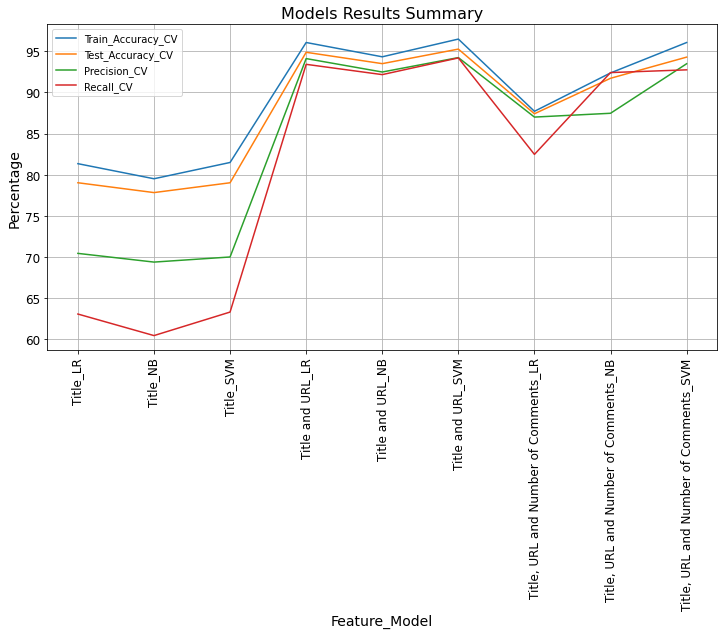

In [0]:
print("LR: Logistic Regression, NB: Naive Bayes (Multinomial), SVM: Support Vector Machine, CV: Cross Validation\n")
results_df.plot("Features_Model", y= ["Train_Accuracy_CV", "Test_Accuracy_CV","Precision_CV","Recall_CV"], figsize= (12,6))
plt.grid()
plt.ylabel("Percentage", size= 14)
plt.xlabel("Feature_Model", size=14)
plt.title("Models Results Summary", size= 16)
plt.xticks(size= 12, rotation='vertical')
plt.yticks(size=12)
plt.show()

**Explanation**

Using the first feature set (Title only) gives an accuracy of around 80% whereas the recall and precision are on the lower side. This is because the imbalanced classes (AskReddit and AdviceAnimals) are being classified as the majority classes (soccer and worldnews).

Including URL in the features gives very impressive results in all three metrics. As understood in the EDA (Importance of Features), URL contained terms which had a very high importance on the subreddit category. For example, one of the term was askreddit itself. In terms of the models, all three did a relatively similar job.

Including the number of comments does not have a considerable impact on the metrics. However, SVM produces slightly better results with this feature set. Running this feature set was computationally more expensive compared for the first two feature sets.

Best Model and feature set: Title and URL_SVM 

### Confusion Matrix

This section is used to illustrate the results of the best feature set and model in a confusion matrix.

In [0]:
X3= data['url_clean'] + data['title_clean']
y3= data['subreddit']

In [0]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state = 42)

In [0]:
tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 1000, ngram_range= (1,2))

In [0]:
tfidf_train = tfidf_vectorizer.fit_transform(X3_train)
tfidf_test = tfidf_vectorizer.transform(X3_test) # Transform the test data: tfidf_test 

In [0]:
model= LinearSVC()
model.fit(tfidf_train,y3_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [0]:
train_predictions= model.predict(tfidf_train)
test_predictions= model.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y3_train, train_predictions)
accuracy_test= metrics.accuracy_score(y3_test, test_predictions)
print("Train Set Accuracy:", round(accuracy_train,3))
print("Test Set Accuracy:", round(accuracy_test, 3))

print("\nOther Metrics:\n", metrics.classification_report(y3_test, test_predictions))

Train Set Accuracy: 0.963
Test Set Accuracy: 0.955

Other Metrics:
                precision    recall  f1-score   support

AdviceAnimals       0.86      0.85      0.86      1053
    AskReddit       1.00      1.00      1.00      1515
       soccer       0.96      0.93      0.95      4487
    worldnews       0.95      0.98      0.97      5955

     accuracy                           0.95     13010
    macro avg       0.94      0.94      0.94     13010
 weighted avg       0.95      0.95      0.95     13010



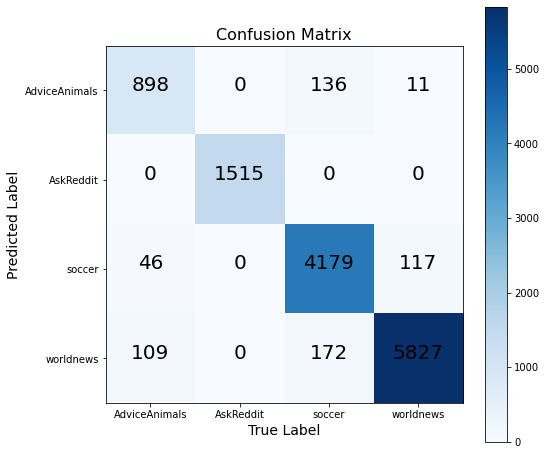

In [0]:
#Lets create a confusion matrix to visualize the predictions
#defining the confusion matrix
cm = metrics.confusion_matrix(test_predictions,y3_test, labels= np.unique(y3))
cmDF = pd.DataFrame()

for i, row in enumerate(np.unique(y3)):
    temp = {}
    for j, col in enumerate(np.unique(y3)): 
        temp[col]=cm[i,j]
    cmDF = cmDF.append(pd.DataFrame.from_dict({row:temp}, orient='index'))

#Plotting the confusion matrix
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=16)
plt.colorbar()
tick_marks = np.arange(len(np.unique(y3)))
plt.xticks(tick_marks, np.unique(y3), fontsize=10)
plt.yticks(tick_marks, np.unique(y3), fontsize=10)
plt.xlabel('True Label', fontsize=14)
plt.ylabel('Predicted Label', fontsize=14)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] < 0:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=20)

**Explanation**

As indicated in the EDA, including the URL as a feature helps to classify the AskReddit subreddit perfectly in this case. This is a major reason why the metric values were high. AskReddit is one of the imbalanced classes and was being misclassified in the first feature set (with title only). This could be understood as giving an unfair advantage to the model, however, the results are still presented here with and without the URL feature set.

AdviceAnimals still struggles to be classified and has a relatively lower precision and recall value. They are being misclassified as one of the two majority classes. This is possibly because the AdviceAnimals subreddit did not contain specific themes and they were more general.

### Hyperparameter Tuning

This is done in two parts:
1. Tuning the TFIDF parameters such as number of features and ngram range
2. Tuning the hyperparameters of the ML model

ngrams is a useful tool used in NLP to include bigram features. Some terms such as United States make more sense together than seperately.The default is (1,1).

Example of range(1,2)
"an apple a day keeps the doctor away"

{'an': 0, 'apple': 2, 'day': 5, 'keeps': 9, 'the': 11, 'doctor': 7, 'away': 4, 'an apple': 1, 'apple day': 3, 'day keeps': 6, 'keeps the': 10, 'the doctor': 12, 'doctor away': 8}

Source: https://www.kaggle.com/c/avito-demand-prediction/discussion/58819

The model and feature set chosen from improvement is Logistic Regression with the first feature set (Title only). It is understood that using URL is giving an unfair advantage specially with the AskReddit subreddit and hence it is not being used in this case. For the model, LR gave comparable results compared to the other models.

Model performance using CV:
- Average Train Accuracy= 81.34% (0.13%)
- Average Test Accuracy= 79.02% (0.72%)
- Average Precision= 70.44% (1.21)%
- Average Recall= 63.08% (0.49%)

In [0]:
df_train_accuracy= pd.DataFrame()
df_test_accuracy= pd.DataFrame()
df_precision= pd.DataFrame()
df_recall= pd.DataFrame()

X1= data['title_clean']
y1= data['subreddit']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state = 42)

ngrams= [(1,1),(1,2),(2,2)]
i=0

for i in range(len(ngrams)) : #loop for the different ngram options
    accuracy_train= []
    accuracy_test= []
    precision= []
    recall= []
    for features in range(1000,6000,1000): #loop for the different count of features
    
        tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= features, ngram_range= ngrams[i])
        tfidf_train = tfidf_vectorizer.fit_transform(X1_train)
        tfidf_test = tfidf_vectorizer.transform(X1_test)

        model= LogisticRegression()
        model.fit(tfidf_train,y1_train)

        train_predictions= model.predict(tfidf_train)
        test_predictions= model.predict(tfidf_test)

        precision.append(metrics.precision_score(y1_test, test_predictions, average= "macro")*100)
        recall.append(metrics.recall_score(y1_test, test_predictions, average= "macro")*100)       
        accuracy_train.append(metrics.accuracy_score(y1_train, train_predictions)*100)
        accuracy_test.append(metrics.accuracy_score(y1_test, test_predictions)*100)
    
    #saving the results in a dataframe for each ngram range choice
    df_train_accuracy["Ngram option: %d" %i]= accuracy_train
    df_test_accuracy["Ngram option: %d" %i]= accuracy_test
    df_precision["Ngram option: %d" %i]= precision
    df_recall["Ngram option: %d" %i]= recall

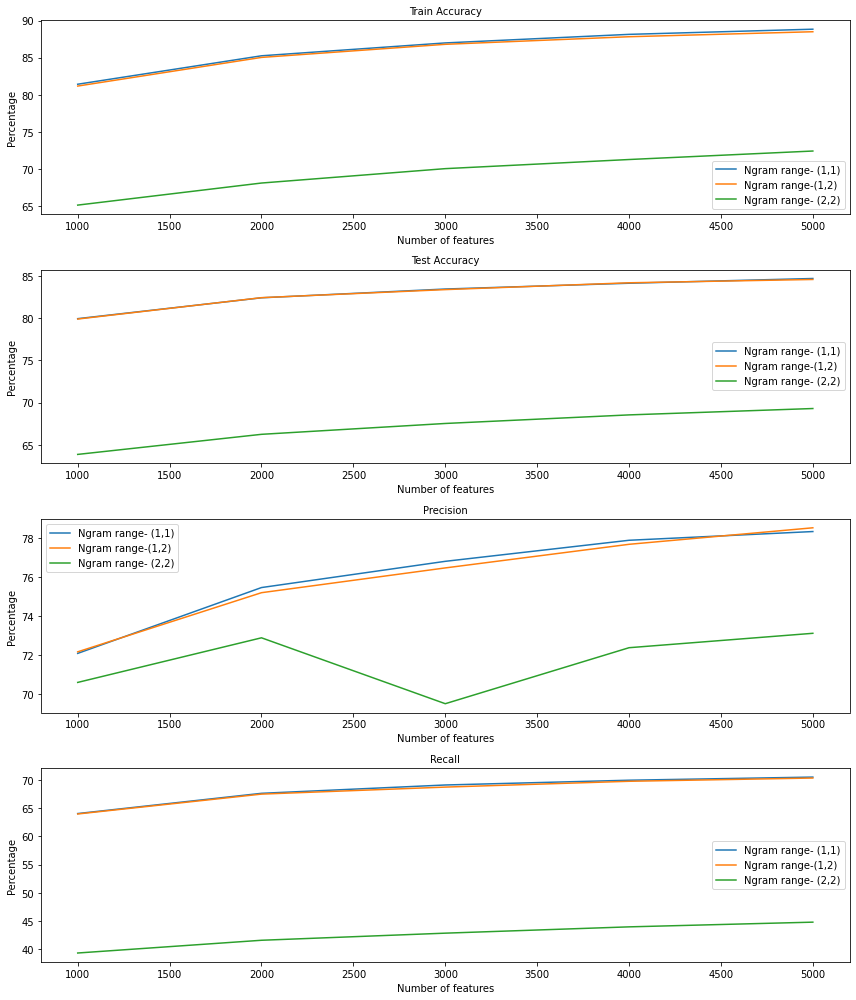

In [0]:
fig, axes = plt.subplots(4, figsize=(12,14))

axes[0].plot(range(1000,6000,1000), df_train_accuracy)
axes[0].set_title("Train Accuracy", fontsize= 10)
axes[0].set_ylabel("Percentage", fontsize=10)
axes[0].set_xlabel("Number of features", fontsize=10)
axes[0].legend(["Ngram range- (1,1)","Ngram range-(1,2)","Ngram range- (2,2)"])

axes[1].plot(range(1000,6000,1000), df_test_accuracy)
axes[1].set_title("Test Accuracy", fontsize= 10)
axes[1].set_ylabel("Percentage", fontsize=10)
axes[1].set_xlabel("Number of features", fontsize=10)
axes[1].legend(["Ngram range- (1,1)","Ngram range-(1,2)","Ngram range- (2,2)"])

axes[2].plot(range(1000,6000,1000), df_precision)
axes[2].set_title("Precision", fontsize= 10)
axes[2].set_ylabel("Percentage", fontsize=10)
axes[2].set_xlabel("Number of features", fontsize=10)
axes[2].legend(["Ngram range- (1,1)","Ngram range-(1,2)","Ngram range- (2,2)"])

axes[3].plot(range(1000,6000,1000), df_recall)
axes[3].set_title("Recall", fontsize= 10)
axes[3].set_ylabel("Percentage", fontsize=10)
axes[3].set_xlabel("Number of features", fontsize=10)
axes[3].legend(["Ngram range- (1,1)","Ngram range-(1,2)","Ngram range- (2,2)"])

fig.tight_layout() #for better layout
plt.show()

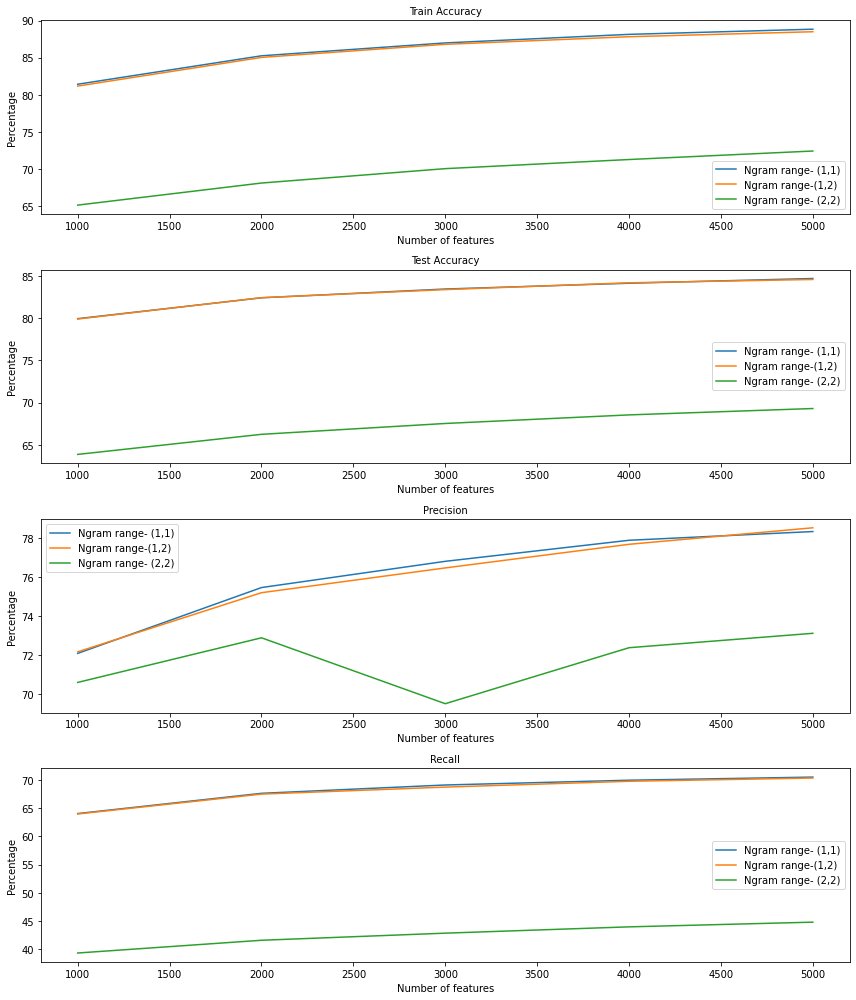

All the metrics seem to increase as the number of TFIDF features are increased. The training accuracy increase indicates that the model might be overfitting. The feature number was not increased further keeping in mind the computational time this code takes. Introducing ngram range did not have a major impact on the results.

Feature number of 5,000 and the default ngram range of (1,1) provide the best results.

In [0]:
kfold = KFold(n_splits=5)
kfold.get_n_splits(X1)

X1= data['title_clean']
y1= data['subreddit']

best_model = None
best_params = {}
best_accuracy = 0
best_std = 0

tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 5000)
#2 hyperparameters being tuned here- C and solver

for C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]:
    for solver in ['newton-cg','lbfgs','sag']:
        
        model = LogisticRegression(C=C, solver=solver)
        accuracy = np.zeros(5)
        np_idx = 0
        
        for train_idx, test_idx in kfold.split(X1):
            X_train, X_test = X1.values[train_idx], X1.values[test_idx]
            y_train, y_test = y1.values[train_idx], y1.values[test_idx]

            tfidf_train = tfidf_vectorizer.fit_transform(X_train)
            tfidf_test = tfidf_vectorizer.transform(X_test)
      
            model.fit(tfidf_train, y_train)
            predictions = model.predict(tfidf_test)

            ACC= metrics.accuracy_score(y_test, predictions)*100
            accuracy[np_idx] = ACC
            np_idx += 1    
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 1, 'solver': 'newton-cg'}
Best Score: 84.042%(0.524%)

The optimal log model uses C=1, and a newton-cg solver, and has a cross validation score of 84.042% with a standard deviation of 0.524%


{'C': 1, 'solver': 'newton-cg'}
Best Score: 84.042%(0.524%)

The optimal log model uses C=1, and a newton-cg solver, and has a cross validation score of 84.042% with a standard deviation of 0.524%

##### Final model with the best parameters

In [0]:
X1= data['title_clean']
y1= data['subreddit']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state = 42)

In [0]:
tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 5000)
tfidf_train = tfidf_vectorizer.fit_transform(X1_train)
tfidf_test = tfidf_vectorizer.transform(X1_test)

In [0]:
model = LogisticRegression(C=1, solver='newton-cg')
model.fit(tfidf_train, y1_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
train_predictions= model.predict(tfidf_train)
test_predictions= model.predict(tfidf_test)

accuracy_train = metrics.accuracy_score(y1_train, train_predictions)
accuracy_test= metrics.accuracy_score(y1_test, test_predictions)
print("Train Set Accuracy:", round(accuracy_train,3))
print("Test Set Accuracy:", round(accuracy_test, 3))

print("\nOther Metrics:\n", metrics.classification_report(y1_test, test_predictions))

Train Set Accuracy: 0.888
Test Set Accuracy: 0.847

Other Metrics:
                precision    recall  f1-score   support

AdviceAnimals       0.61      0.31      0.41      1053
    AskReddit       0.76      0.66      0.71      1515
       soccer       0.93      0.91      0.92      4487
    worldnews       0.83      0.94      0.88      5955

     accuracy                           0.85     13010
    macro avg       0.78      0.71      0.73     13010
 weighted avg       0.84      0.85      0.84     13010



Summary of the hyperparameter tuning results:
- Train Accuracy increased from 81% to 89%
- Test Accuracy increased from 79% to 85%
- Precision increased from 70% to 78%
- Recall increased from 63% to 71%

## Part 4: Sentiment Analysis

### Vader score per title

In [0]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        titleDf = pd.DataFrame(pdlist)
        titleDf.columns = columns
        return titleDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [0]:
title = data['title_clean'].values
titleDf = evalSentences(title, to_df=True, columns=['titleCol','vader'])

100%|██████████| 43365/43365 [00:06<00:00, 6909.58it/s]


In [0]:
titleDf= titleDf.join(data['subreddit'].reset_index(drop= True))
titleDf.head()

,titleCol,vader,subreddit
0,india chinese woman 25 solo trip khajuraho raped,-0.6808,worldnews
1,serious american liberals without sarcasm one ...,0.7761,AskReddit
2,according fiji government australian terrorist...,-0.6908,worldnews
3,wife adamant getting pregnant masters told use...,0.0000,AdviceAnimals
4,winter transfer window officially open,0.0000,soccer


### Vader score distribution per subreddit

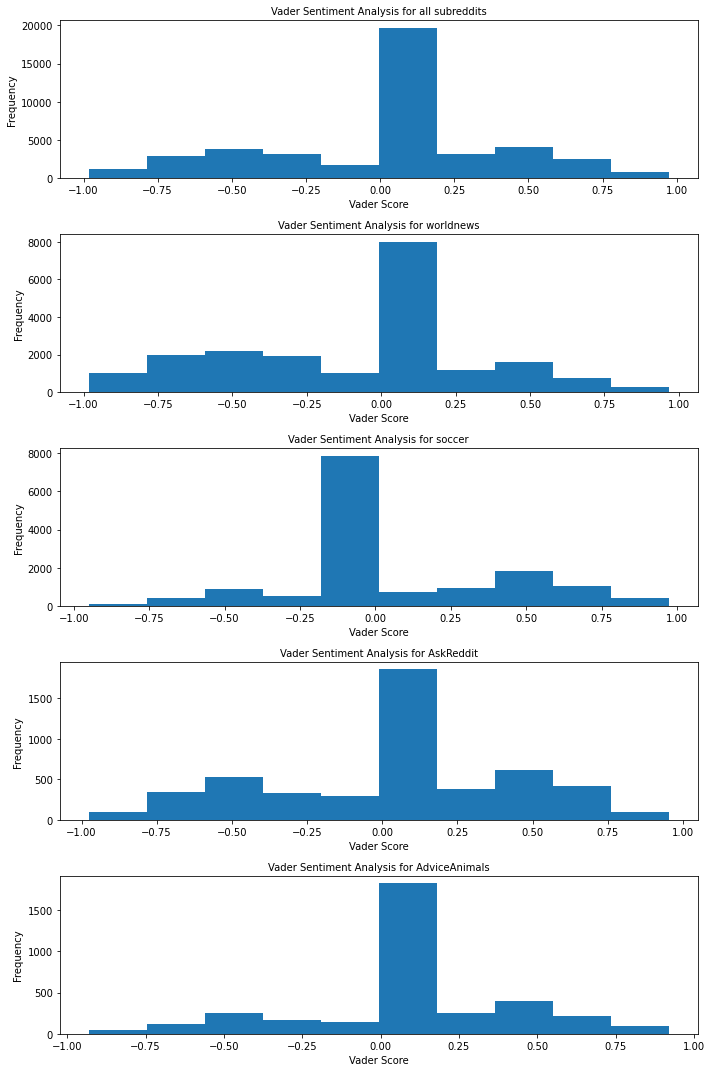

In [0]:
fig, axes = plt.subplots(5, figsize=(10,15))

axes[0].hist(titleDf.vader.values)
axes[0].set_title("Vader Sentiment Analysis for all subreddits", fontsize= 10)
axes[0].set_ylabel("Frequency", fontsize=10)
axes[0].set_xlabel("Vader Score", fontsize=10)

axes[1].hist(titleDf.vader[titleDf.subreddit=="worldnews"].values)
axes[1].set_title("Vader Sentiment Analysis for worldnews", fontsize= 10)
axes[1].set_ylabel("Frequency", fontsize=10)
axes[1].set_xlabel("Vader Score", fontsize=10)

axes[2].hist(titleDf.vader[titleDf.subreddit=="soccer"].values)
axes[2].set_title("Vader Sentiment Analysis for soccer", fontsize= 10)
axes[2].set_ylabel("Frequency", fontsize=10)
axes[2].set_xlabel("Vader Score", fontsize=10)

axes[3].hist(titleDf.vader[titleDf.subreddit=="AskReddit"].values)
axes[3].set_title("Vader Sentiment Analysis for AskReddit", fontsize= 10)
axes[3].set_ylabel("Frequency", fontsize=10)
axes[3].set_xlabel("Vader Score", fontsize=10)

axes[4].hist(titleDf.vader[titleDf.subreddit=="AdviceAnimals"].values)
axes[4].set_title("Vader Sentiment Analysis for AdviceAnimals", fontsize= 10)
axes[4].set_ylabel("Frequency", fontsize=10)
axes[4].set_xlabel("Vader Score", fontsize=10)

fig.tight_layout() #for better layout
plt.show()

**Explanation**

The graphs above indicate that most titles are neutral (they have a vader score between 0 to 0.25 for all subreddits except soccer. Soccer has the highest frequency between -0.25 to 0.

It would be sensible to used a vader score greater than +0.5 as positive and a vader score lower than -0.5 as negative to have enough data.

### Sentiment Labels

In [0]:
threshold= 0.5
titleDf_mod= titleDf[(titleDf.vader>threshold) | (titleDf.vader<-threshold)]

In [0]:
print("#Rows before introducing the threshold:" ,titleDf.shape[0])
print("#Rows after introducing the threshold:" ,titleDf_mod.shape[0])

#Rows before introducing the threshold: 43365
#Rows after introducing the threshold: 10276


In [0]:
titleDf_mod.loc[titleDf_mod.vader> threshold, 'Label'] = "positive"
titleDf_mod.loc[titleDf_mod.vader< -threshold, 'Label'] = "negative"
titleDf_mod.head()

,titleCol,vader,subreddit,Label
0,india chinese woman 25 solo trip khajuraho raped,-0.6808,worldnews,negative
1,serious american liberals without sarcasm one ...,0.7761,AskReddit,positive
2,according fiji government australian terrorist...,-0.6908,worldnews,negative
6,great living chola temples unveiling ancient i...,0.6249,worldnews,positive
11,russia outlaws animal cruelty,-0.5994,worldnews,negative


For the last part in this section, subreddit analysis will be done using the Top K words and Top K noun phrases in both positive and negative posts. These two metrics will be used to understand if there is a specific pattern for both positive and negatives in each subreddit. These two metrics will help identify if there any specific themes/patters in each subreddit.

### Top K terms and Top K noun phrases

In [0]:
def getTopK(df, k, label_value, label_column='Label', operation=operator.eq, value_column='titleCol'):
    from nltk.corpus import stopwords
    stop = set(stopwords.words('english'))
    stop.add('would')
    #Add possible Stop Words for Hotel Reviews
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word 
                            in tokenize.regexp.regexp_tokenize(review, pattern='\w+') 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [0]:
topkLabelPos = getTopK(df=titleDf_mod, k=50, label_value='positive')
topkLabelPos

[('best', 596),
 ('free', 350),
 ('win', 282),
 ('united', 261),
 ('league', 229),
 ('great', 226),
 ('like', 221),
 ('new', 216),
 ('club', 206),
 ('year', 180),
 ('world', 179),
 ('player', 178),
 ('one', 177),
 ('cup', 166),
 ('people', 148),
 ('2019', 147),
 ('team', 142),
 ('top', 141),
 ('manchester', 139),
 ('football', 137),
 ('play', 137),
 ('love', 137),
 ('get', 134),
 ('first', 132),
 ('says', 129),
 ('goal', 129),
 ('time', 125),
 ('chelsea', 125),
 ('good', 124),
 ('amp', 120),
 ('city', 118),
 ('happy', 116),
 ('agreement', 116),
 ('trump', 115),
 ('season', 114),
 ('years', 113),
 ('game', 109),
 ('super', 107),
 ('help', 106),
 ('deal', 105),
 ('wins', 103),
 ('psg', 100),
 ('barcelona', 99),
 ('last', 96),
 ('make', 95),
 ('winning', 95),
 ('join', 94),
 ('champions', 93),
 ('madrid', 93),
 ('liverpool', 92)]

In [0]:
topkLabelNeg = getTopK(df=titleDf_mod, k=50, label_value='negative')
topkLabelNeg

[('death', 273),
 ('trump', 272),
 ('killed', 243),
 ('police', 240),
 ('dead', 233),
 ('says', 228),
 ('people', 225),
 ('new', 222),
 ('attack', 205),
 ('china', 190),
 ('year', 188),
 ('war', 179),
 ('man', 164),
 ('arrested', 162),
 ('worst', 152),
 ('world', 146),
 ('crisis', 145),
 ('one', 134),
 ('ban', 130),
 ('woman', 126),
 ('two', 120),
 ('syria', 119),
 ('years', 118),
 ('news', 111),
 ('saudi', 109),
 ('kill', 108),
 ('thing', 107),
 ('abuse', 105),
 ('bad', 104),
 ('could', 102),
 ('say', 102),
 ('murder', 101),
 ('state', 101),
 ('president', 98),
 ('violence', 96),
 ('first', 94),
 ('accused', 93),
 ('said', 93),
 ('rape', 91),
 ('old', 90),
 ('killing', 90),
 ('israeli', 88),
 ('border', 88),
 ('women', 87),
 ('venezuela', 87),
 ('india', 86),
 ('government', 86),
 ('die', 85),
 ('brazil', 84),
 ('right', 83)]

The above results are done for all the subreddits combined. This is not a fair comparision as we have noticed in the EDA, that there are imbalanced classes.

However, it is interesting to note how terms like best, free, win, united (assuming it is Manchester United) bring a lot of joy to people. These terms seem to be dominated by the soccer subreddit.

For the negative terms, there are Trump, police, killed and these terms seem to be dominated largely by the worldnews subreddit.

In [0]:
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

In [0]:
tagger = PerceptronTagger()
pos_tag = tagger.tag
# Create phrase tree
chunker = nltk.RegexpParser(grammar)

In [0]:
# Noun Phrase Extraction Support Functions
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w)]
        # Phrase only
        if len(term)>1:
            yield term

In [0]:
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [0]:
def getTopKNounPhrases(df, k, label_value, label_column='Label', operation=operator.eq, value_column='titleCol'):
    from nltk.corpus import stopwords
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update(flatten([word for word in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))]))
    topk = counter.most_common(k)
    return topk

In [0]:
topkNounLabelPos = getTopKNounPhrases(df=titleDf_mod, k=50, label_value='positive')
topkNounLabelPos

[('free kick', 30),
 ('cristiano ronaldo', 20),
 ('great goal', 14),
 ('fa cup', 13),
 ('confid vote', 12),
 ('unit state', 11),
 ('suprem court', 10),
 ('donald trump', 9),
 ('senegales player year', 9),
 ('offici koulibali beat', 8),
 ('happi new year', 8),
 ('ole gunnar solskjaer', 8),
 ('year contract', 8),
 ('win titl', 8),
 ('video game', 8),
 ('politico playbook', 8),
 ('leagu game', 7),
 ('win trophi', 7),
 ('van dijk', 7),
 ('eden hazard', 7),
 ('govern surviv confid vote', 7),
 ('free premi um maga', 7),
 ('maga hat', 7),
 ('ship click link get', 7),
 ('world cup', 6),
 ('fit workout motiv', 6),
 ('ju wurk atlanta ga', 6),
 ('ju wurk', 6),
 ('soni vega', 6),
 ('pep guardiola', 6),
 ('manchest unit ole gunnar solskjaer', 6),
 ('marcelo bielsa', 6),
 ('new year', 5),
 ('big bank', 5),
 ('end season', 5),
 ('ladi gaga', 5),
 ('ac milan', 5),
 ('european leagu', 5),
 ('agreement inter milan', 5),
 ('new music', 5),
 ('dog love', 5),
 ('petr cech trophi strewn career result', 5),


In [0]:
topkNounLabelPos = getTopKNounPhrases(df=titleDf_mod, k=50, label_value='negative')
topkNounLabelPos

[('saudi arabia', 22),
 ('wayn rooney', 16),
 ('saudi woman', 15),
 ('brazil dam collaps', 13),
 ('cristiano ronaldo', 12),
 ('year prison', 12),
 ('death toll', 11),
 ('climat chang', 11),
 ('terror attack', 10),
 ('death threat', 10),
 ('pari son rememb', 10),
 ('right violenc', 10),
 ('crimin charg', 10),
 ('death penalti', 9),
 ('british soldier', 9),
 ('multipl death', 9),
 ('video game', 8),
 ('venezuela crisi', 8),
 ('fake news', 8),
 ('cure cancer', 8),
 ('taliban attack', 7),
 ('social medium', 7),
 ('islam state attack syria', 7),
 ('donald trump', 7),
 ('car bomb', 7),
 ('journalist ghana', 7),
 ('doomsday clock', 7),
 ('palestinian man shot dead settler violenc', 7),
 ('gay men', 6),
 ('teenag girl', 6),
 ('worst thing', 6),
 ('chelsea fan', 6),
 ('trade war', 6),
 ('suffici un saudi trial jamal khashoggi', 6),
 ('escap room fire', 6),
 ('white victim black crime', 6),
 ('racial protest', 6),
 ('conspiraci theori', 6),
 ('palestinian woman', 6),
 ('princ philip', 6),
 ('isr

There are less noun phrases than there were words. This is because people would not always use Saudi Arabia, they might used other terms to define it such as KSA or just Saudi.

However, a similar trend is noticed here just as the Top K terms where majority of the terms seem to be from soccer and worldnews subreddit.

#### Subreddit- worldnews 

In [0]:
topkLabelPos_worldnews = getTopK(df=titleDf_mod[titleDf_mod.subreddit== "worldnews"], k=50, label_value='positive')
topkLabelPos_worldnews

[('best', 147),
 ('free', 127),
 ('new', 126),
 ('2019', 86),
 ('trump', 80),
 ('says', 78),
 ('win', 73),
 ('world', 72),
 ('year', 51),
 ('government', 51),
 ('people', 49),
 ('peace', 48),
 ('help', 48),
 ('vote', 48),
 ('may', 48),
 ('super', 45),
 ('confidence', 45),
 ('wins', 44),
 ('great', 42),
 ('china', 42),
 ('first', 42),
 ('united', 41),
 ('court', 41),
 ('support', 40),
 ('love', 40),
 ('top', 38),
 ('get', 36),
 ('years', 35),
 ('president', 34),
 ('supreme', 34),
 ('video', 33),
 ('party', 33),
 ('security', 32),
 ('said', 31),
 ('cup', 31),
 ('taliban', 30),
 ('like', 30),
 ('country', 30),
 ('talks', 29),
 ('online', 29),
 ('day', 29),
 ('trade', 29),
 ('winning', 28),
 ('one', 28),
 ('amp', 28),
 ('leader', 27),
 ('russian', 27),
 ('australian', 27),
 ('justice', 27),
 ('000', 26)]

In [0]:
topkLabelNeg_worldnews = getTopK(df=titleDf_mod[titleDf_mod.subreddit== "worldnews"], k=50, label_value='negative')
topkLabelNeg_worldnews

[('trump', 253),
 ('death', 241),
 ('killed', 232),
 ('says', 202),
 ('police', 200),
 ('new', 198),
 ('dead', 196),
 ('attack', 194),
 ('china', 188),
 ('war', 167),
 ('year', 158),
 ('crisis', 136),
 ('man', 132),
 ('arrested', 131),
 ('woman', 121),
 ('world', 121),
 ('people', 119),
 ('syria', 119),
 ('saudi', 108),
 ('two', 106),
 ('news', 99),
 ('murder', 97),
 ('state', 96),
 ('ban', 94),
 ('violence', 89),
 ('president', 88),
 ('israeli', 87),
 ('venezuela', 87),
 ('india', 85),
 ('accused', 85),
 ('killing', 85),
 ('one', 84),
 ('brazil', 84),
 ('years', 82),
 ('border', 82),
 ('government', 81),
 ('canadian', 80),
 ('kills', 80),
 ('kill', 77),
 ('russia', 76),
 ('women', 76),
 ('court', 75),
 ('say', 75),
 ('said', 73),
 ('abuse', 73),
 ('may', 72),
 ('amid', 71),
 ('could', 71),
 ('canada', 71),
 ('old', 70)]

In [0]:
topkNounLabelPos_worldnews = getTopKNounPhrases(df=titleDf_mod[titleDf_mod.subreddit== "worldnews"], k=50, label_value='positive')
topkNounLabelPos_worldnews

[('confid vote', 12),
 ('suprem court', 10),
 ('unit state', 8),
 ('politico playbook', 8),
 ('govern surviv confid vote', 7),
 ('free premi um maga', 7),
 ('maga hat', 7),
 ('ship click link get', 7),
 ('fit workout motiv', 6),
 ('ju wurk atlanta ga', 6),
 ('ju wurk', 6),
 ('win titl', 6),
 ('big bank', 5),
 ('ladi gaga', 5),
 ('new music', 5),
 ('fa cup', 5),
 ('naomi osaka beat', 5),
 ('taliban talk', 5),
 ('signific progress', 5),
 ('free agenc', 4),
 ('velg mobil', 4),
 ('new democrat kingmak rate surg posit', 4),
 ('boost favorit candid', 4),
 ('manchest unit ole gunnar solskjaer', 4),
 ('fx pose televis power depict unselfish love', 4),
 ('partisan gerrymand year', 4),
 ('nba trade idea', 4),
 ('buzz deal', 4),
 ('bradley beal nic batum', 4),
 ('wall street bonu season', 4),
 ('golden globe', 4),
 ('johanna konta', 4),
 ('sydney intern heather watson', 4),
 ('uk govern', 4),
 ('hors race polit journal awesom', 4),
 ('top berni sander', 4),
 ('saudi woman case', 4),
 ('campaign h

In [0]:
topkNounLabelNeg_worldnews = getTopKNounPhrases(df=titleDf_mod[titleDf_mod.subreddit== "worldnews"], k=50, label_value='negative')
topkNounLabelNeg_worldnews 

[('saudi arabia', 22),
 ('saudi woman', 15),
 ('brazil dam collaps', 13),
 ('death toll', 11),
 ('year prison', 11),
 ('climat chang', 11),
 ('terror attack', 10),
 ('pari son rememb', 10),
 ('right violenc', 10),
 ('crimin charg', 10),
 ('death threat', 9),
 ('british soldier', 9),
 ('multipl death', 9),
 ('venezuela crisi', 8),
 ('cure cancer', 8),
 ('taliban attack', 7),
 ('death penalti', 7),
 ('islam state attack syria', 7),
 ('fake news', 7),
 ('car bomb', 7),
 ('doomsday clock', 7),
 ('palestinian man shot dead settler violenc', 7),
 ('gay men', 6),
 ('teenag girl', 6),
 ('trade war', 6),
 ('suffici un saudi trial jamal khashoggi', 6),
 ('social medium', 6),
 ('escap room fire', 6),
 ('white victim black crime', 6),
 ('racial protest', 6),
 ('palestinian woman', 6),
 ('donald trump', 6),
 ('princ philip', 6),
 ('isra student', 6),
 ('underestim speaker', 6),
 ('shutdown battl', 6),
 ('countri pick side venezuela crisi', 6),
 ('bodi part', 6),
 ('bomb threat', 5),
 ('rat hole min

**Explanation**

It seems clear that terms such as Saudi Arabia, killed or even Trump are more associated with the negative sentiment in the subreddit. Trump also shows up in the positive terms but with way lower of a frequency. As expected, the worldnews subreddit is majorly of negative sentiment.
There are not a lot of happy (positive) news that is reported in general.

#### Subreddit- soccer

In [0]:
topkLabelPos_soccer = getTopK(df=titleDf_mod[titleDf_mod.subreddit== "soccer"], k=50, label_value='positive')
topkLabelPos_soccer

[('best', 267),
 ('league', 218),
 ('united', 216),
 ('win', 199),
 ('club', 195),
 ('free', 179),
 ('player', 174),
 ('great', 142),
 ('football', 136),
 ('cup', 134),
 ('team', 133),
 ('manchester', 126),
 ('goal', 124),
 ('chelsea', 119),
 ('play', 115),
 ('year', 112),
 ('one', 107),
 ('season', 106),
 ('barcelona', 99),
 ('agreement', 99),
 ('city', 97),
 ('like', 97),
 ('psg', 97),
 ('top', 95),
 ('madrid', 93),
 ('liverpool', 87),
 ('world', 86),
 ('amp', 85),
 ('deal', 85),
 ('real', 83),
 ('join', 83),
 ('transfer', 83),
 ('milan', 80),
 ('first', 77),
 ('contract', 77),
 ('champions', 75),
 ('kick', 74),
 ('players', 73),
 ('premier', 72),
 ('years', 69),
 ('new', 68),
 ('last', 67),
 ('time', 67),
 ('game', 67),
 ('happy', 66),
 ('sign', 66),
 ('winning', 66),
 ('messi', 65),
 ('arsenal', 65),
 ('soccer', 64)]

In [0]:
topkLabelNeg_soccer = getTopK(df=titleDf_mod[titleDf_mod.subreddit== "soccer"], k=50, label_value='negative')
topkLabelNeg_soccer

[('football', 58),
 ('fans', 51),
 ('chelsea', 50),
 ('player', 45),
 ('penalty', 44),
 ('ronaldo', 42),
 ('club', 38),
 ('game', 36),
 ('injury', 36),
 ('city', 35),
 ('amp', 33),
 ('police', 33),
 ('racist', 32),
 ('cup', 31),
 ('players', 31),
 ('arrested', 31),
 ('ban', 30),
 ('league', 30),
 ('real', 30),
 ('cristiano', 29),
 ('abuse', 29),
 ('season', 29),
 ('transfer', 28),
 ('one', 28),
 ('last', 28),
 ('sala', 28),
 ('team', 27),
 ('psg', 27),
 ('madrid', 26),
 ('rejected', 26),
 ('games', 26),
 ('dead', 26),
 ('time', 25),
 ('miss', 25),
 ('barcelona', 25),
 ('soccer', 24),
 ('arsenal', 23),
 ('liverpool', 23),
 ('first', 23),
 ('year', 23),
 ('years', 22),
 ('man', 22),
 ('racism', 21),
 ('cardiff', 21),
 ('says', 21),
 ('worst', 21),
 ('emiliano', 21),
 ('match', 20),
 ('public', 20),
 ('lost', 19)]

In [0]:
topkNounLabelPos_soccer = getTopKNounPhrases(df=titleDf_mod[titleDf_mod.subreddit== "soccer"], k=50, label_value='positive')
topkNounLabelPos_soccer

[('free kick', 30),
 ('cristiano ronaldo', 20),
 ('great goal', 14),
 ('senegales player year', 9),
 ('offici koulibali beat', 8),
 ('ole gunnar solskjaer', 8),
 ('year contract', 8),
 ('fa cup', 8),
 ('leagu game', 7),
 ('van dijk', 7),
 ('eden hazard', 7),
 ('world cup', 6),
 ('pep guardiola', 6),
 ('marcelo bielsa', 6),
 ('end season', 5),
 ('ac milan', 5),
 ('european leagu', 5),
 ('win trophi', 5),
 ('agreement inter milan', 5),
 ('petr cech trophi strewn career result', 5),
 ('enjoy scbastia n3 fifth last tier team', 5),
 ('franc forza bastia', 5),
 ('happi new year', 4),
 ('like play great team contract', 4),
 ('situat market offer', 4),
 ('man citi', 4),
 ('ole gunnar solskjær', 4),
 ('histori win', 4),
 ('lev yashin', 4),
 ('mauricio pochettino', 4),
 ('free talk friday', 4),
 ('di marzio', 4),
 ('godin free summer', 4),
 ('clean sheet', 4),
 ('happi birthday', 4),
 ('real madrid messi', 4),
 ('exampl frank lampard', 4),
 ('seri sever year', 4),
 ('juve challeng', 4),
 ('train

In [0]:
topkNounLabelNeg_soccer = getTopKNounPhrases(df=titleDf_mod[titleDf_mod.subreddit== "soccer"], k=50, label_value='negative')
topkNounLabelNeg_soccer

[('wayn rooney', 13),
 ('cristiano ronaldo', 9),
 ('chelsea fan', 6),
 ('journalist ghana', 5),
 ('manuel neuer', 5),
 ('bayern munich statsbomb', 5),
 ('real madrid', 4),
 ('match ban', 4),
 ('public intox', 4),
 ('racial abus', 4),
 ('dead space instant access', 4),
 ('polic issu', 4),
 ('soccer superstar ronaldo dna rape case', 4),
 ('milan doctor brozzi', 4),
 ('derogatori arrog tone', 4),
 ('prison sentenc', 4),
 ('rape alleg', 3),
 ('craig bellami', 3),
 ('fifa rule', 3),
 ('uefa investig', 3),
 ('charli austin', 3),
 ('public intox swear', 3),
 ('la vega polic', 3),
 ('manchest citi', 3),
 ('fifa corrupt shot', 3),
 ('thing point', 3),
 ('season imagin feel', 3),
 ('mad mad player qualiti', 3),
 ('emiliano sala', 3),
 ('crimin damag', 3),
 ('millwal fan', 3),
 ('aboubakar kamara', 2),
 ('pulis chelsea america insist', 2),
 ('pa classic', 2),
 ('solidar payment', 2),
 ('fee tragic', 2),
 ('season game', 2),
 ('penalti shootout winner', 2),
 ('point new rule', 2),
 ('pep guardiola

**Explanation**

Soccer has a higher frequency of terms in positive sentiment. Terms like United, Ronaldo indicate the popular items in this subreddit. The theme is very clear here and people who have a negative sentiment are fans of the team that might have lost the game. Hence there are repeated terms in both the positive and negative list.

#### Subreddit- AskReddit

In [0]:
topkLabelPos_askreddit = getTopK(df=titleDf_mod[titleDf_mod.subreddit== "AskReddit"], k=50, label_value='positive')
topkLabelPos_askreddit

[('best', 140),
 ('like', 66),
 ('people', 57),
 ('love', 32),
 ('trump', 29),
 ('game', 29),
 ('good', 28),
 ('time', 28),
 ('favorite', 27),
 ('think', 27),
 ('one', 26),
 ('something', 26),
 ('life', 26),
 ('movie', 26),
 ('thing', 25),
 ('great', 25),
 ('ever', 25),
 ('greatest', 24),
 ('get', 24),
 ('way', 23),
 ('free', 21),
 ('serious', 20),
 ('wish', 20),
 ('make', 19),
 ('happy', 19),
 ('someone', 17),
 ('country', 17),
 ('redditors', 16),
 ('video', 16),
 ('food', 16),
 ('popular', 16),
 ('joke', 16),
 ('better', 15),
 ('makes', 15),
 ('sex', 15),
 ('song', 15),
 ('could', 14),
 ('world', 14),
 ('really', 14),
 ('say', 13),
 ('show', 13),
 ('america', 13),
 ('donald', 12),
 ('fun', 12),
 ('opinion', 12),
 ('everyone', 12),
 ('things', 12),
 ('new', 11),
 ('honest', 11),
 ('play', 11)]

In [0]:
topkLabelNeg_askreddit = getTopK(df=titleDf_mod[titleDf_mod.subreddit== "AskReddit"], k=50, label_value='negative')
topkLabelNeg_askreddit

[('worst', 104),
 ('thing', 96),
 ('people', 82),
 ('ever', 58),
 ('die', 39),
 ('bad', 33),
 ('hate', 32),
 ('serious', 30),
 ('someone', 30),
 ('something', 28),
 ('think', 27),
 ('stupid', 26),
 ('death', 24),
 ('kill', 24),
 ('dumbest', 24),
 ('person', 23),
 ('get', 21),
 ('one', 21),
 ('fuck', 20),
 ('hell', 20),
 ('life', 20),
 ('could', 20),
 ('way', 20),
 ('done', 18),
 ('say', 18),
 ('movie', 18),
 ('illegal', 18),
 ('video', 17),
 ('know', 16),
 ('time', 16),
 ('going', 16),
 ('choose', 15),
 ('seen', 15),
 ('make', 15),
 ('trump', 15),
 ('story', 14),
 ('things', 14),
 ('died', 13),
 ('last', 13),
 ('parents', 13),
 ('really', 13),
 ('child', 13),
 ('game', 13),
 ('find', 12),
 ('sex', 12),
 ('racist', 12),
 ('everyone', 12),
 ('right', 12),
 ('much', 11),
 ('use', 11)]

In [0]:
topkNounLabelPos_askreddit = getTopKNounPhrases(df=titleDf_mod[titleDf_mod.subreddit== "AskReddit"], k=50, label_value='positive')
topkNounLabelPos_askreddit

[('video game', 8),
 ('donald trump', 7),
 ('piec advic', 3),
 ('savior western civil', 3),
 ('tv show', 3),
 ('tim cook', 2),
 ('peopl someth', 2),
 ('dc marvel', 2),
 ('perfect sandwich', 2),
 ('dear american', 2),
 ('seriou trump support', 2),
 ('gamer game', 2),
 ('food peopl', 2),
 ('bezo market plan', 2),
 ('trump support', 2),
 ('good thing', 2),
 ('someon feel', 2),
 ('someth fun', 2),
 ('popular video game', 2),
 ('youtub channel', 2),
 ('border secur', 2),
 ('friend opposit sex', 2),
 ('presid american histori', 2),
 ('white peopl', 2),
 ('unit state', 2),
 ('seriou american liber', 1),
 ('type fart', 1),
 ('success smell', 1),
 ('domin hand fun activ', 1),
 ('new year', 1),
 ('favorit uplift favorit bibl vers', 1),
 ('honest opinion peopl', 1),
 ('toilet comfort seat', 1),
 ('great band song redditor', 1),
 ('celebr new year', 1),
 ('gamer good game peopl', 1),
 ('pleasant sound accent', 1),
 ('way deal hangov', 1),
 ('scale size cat', 1),
 ('possibl love', 1),
 ('peopl time

In [0]:
topkNounLabelNeg_askreddit = getTopKNounPhrases(df=titleDf_mod[titleDf_mod.subreddit== "AskReddit"], k=50, label_value='negative')
topkNounLabelNeg_askreddit

[('video game', 8),
 ('worst thing', 5),
 ('thing someon', 5),
 ('conspiraci theori', 5),
 ('seriou peopl', 4),
 ('last word', 4),
 ('way die', 4),
 ('irrat fear', 3),
 ('dumb thing', 3),
 ('stupid question', 3),
 ('physic pain', 3),
 ('celebr death', 3),
 ('racist thing', 2),
 ('littl thing', 2),
 ('first world problem', 2),
 ('thing gotten', 2),
 ('fuck thing', 2),
 ('men woman', 2),
 ('death penalti', 2),
 ('unhealthi thing', 2),
 ('serial killer', 2),
 ('thing hear', 2),
 ('stupid thing', 2),
 ('horror movi', 2),
 ('person hell', 2),
 ('violent video game', 2),
 ('use gun kill peopl', 2),
 ('question new year', 1),
 ('tell sign', 1),
 ('bf gf', 1),
 ('absolut scam', 1),
 ('last shit', 1),
 ('bad thing celebr', 1),
 ('someth struggl', 1),
 ('unbeliev weird', 1),
 ('die thing new year', 1),
 ('long time', 1),
 ('seriou atheist parent', 1),
 ('sight bare foot', 1),
 ('gross peopl', 1),
 ('masturb as', 1),
 ('nose pick', 1),
 ('gross human habit', 1),
 ('millenni industri', 1),
 ('virg

**Explanation**

AskReddit has a lot more general topics that do not follow a specific theme. It discusses gaming, Trump, tv shows, etc. It is one of the imbalanced class and hence the frequency of the top words is not high. 

However, positive terms include best, like, good, etc. The negative terms include bad, worst, die, hate. Videogame, Donald Trump seem to be popular topics on this subreddit.

#### Subreddit- AdviceAnimals

In [0]:
topkLabelPos_adviceanimals = getTopK(df=titleDf_mod[titleDf_mod.subreddit== "AdviceAnimals"], k=50, label_value='positive')
topkLabelPos_adviceanimals

[('best', 42),
 ('like', 28),
 ('please', 25),
 ('get', 24),
 ('free', 23),
 ('dog', 21),
 ('love', 21),
 ('people', 18),
 ('great', 17),
 ('make', 17),
 ('one', 16),
 ('help', 16),
 ('good', 15),
 ('kind', 15),
 ('fun', 14),
 ('2019', 12),
 ('baby', 12),
 ('new', 11),
 ('loves', 11),
 ('ever', 11),
 ('work', 11),
 ('year', 10),
 ('day', 10),
 ('friend', 10),
 ('happy', 9),
 ('still', 8),
 ('time', 8),
 ('well', 8),
 ('advice', 8),
 ('know', 8),
 ('better', 8),
 ('sure', 8),
 ('life', 8),
 ('right', 8),
 ('think', 8),
 ('want', 8),
 ('give', 7),
 ('never', 7),
 ('friends', 7),
 ('thank', 7),
 ('pretty', 7),
 ('buy', 7),
 ('super', 7),
 ('got', 7),
 ('funny', 7),
 ('world', 7),
 ('always', 7),
 ('hope', 6),
 ('amp', 6),
 ('thanks', 6)]

In [0]:
topkLabelNeg_adviceanimals = getTopK(df=titleDf_mod[titleDf_mod.subreddit== "AdviceAnimals"], k=50, label_value='negative')
topkLabelNeg_adviceanimals

[('shit', 22),
 ('people', 18),
 ('scumbag', 17),
 ('bad', 17),
 ('hate', 15),
 ('fuck', 14),
 ('get', 13),
 ('take', 9),
 ('going', 8),
 ('feel', 8),
 ('stupid', 8),
 ('hurt', 7),
 ('sick', 7),
 ('years', 6),
 ('said', 6),
 ('fire', 6),
 ('depression', 5),
 ('worst', 5),
 ('everyone', 5),
 ('even', 5),
 ('know', 5),
 ('day', 5),
 ('man', 5),
 ('someone', 4),
 ('hell', 4),
 ('rapists', 4),
 ('probably', 4),
 ('rather', 4),
 ('die', 4),
 ('bullshit', 4),
 ('like', 4),
 ('advice', 4),
 ('getting', 4),
 ('kill', 4),
 ('poor', 4),
 ('cat', 4),
 ('seriously', 4),
 ('wtf', 4),
 ('new', 4),
 ('never', 4),
 ('trying', 4),
 ('enough', 4),
 ('tired', 4),
 ('seeing', 4),
 ('police', 4),
 ('bitch', 4),
 ('trump', 4),
 ('think', 4),
 ('thing', 4),
 ('fucking', 4)]

In [0]:
topkNounLabelPos_adviceanimals = getTopKNounPhrases(df=titleDf_mod[titleDf_mod.subreddit== "AdviceAnimals"], k=50, label_value='positive')
topkNounLabelPos_adviceanimals

[('dog love', 5),
 ('soni vega', 3),
 ('sexi time', 2),
 ('fun fact', 2),
 ('plea share', 2),
 ('loyal employe', 2),
 ('help clean', 2),
 ('hard right tool', 2),
 ('super bowl', 2),
 ('great ride deliveri experi', 2),
 ('hero zero', 2),
 ('greet peopl', 2),
 ('chapstick love chapstick life', 2),
 ('fun monkey', 2),
 ('monkey funni video', 2),
 ('mari jane inspir', 2),
 ('mani sweet drink', 2),
 ('hope see', 1),
 ('happi new year', 1),
 ('dog babi', 1),
 ('babi compil', 1),
 ('peopl home', 1),
 ('wish type last night parti', 1),
 ('way leagu', 1),
 ('give chanc', 1),
 ('mani time attract peopl', 1),
 ('hour midnight feel', 1),
 ('boyfriend year award', 1),
 ('pet year', 1),
 ('hour get', 1),
 ('domain free onlin train fee', 1),
 ('job assist work', 1),
 ('internship letter', 1),
 ('experi letter', 1),
 ('panama paper', 1),
 ('solid advic good new year treat other', 1),
 ('good thing', 1),
 ('free gift card', 1),
 ('card rebel', 1),
 ('special charact', 1),
 ('rubik cube dark', 1),
 ('je

In [0]:
topkNounLabelNeg_adviceanimals = getTopKNounPhrases(df=titleDf_mod[titleDf_mod.subreddit== "AdviceAnimals"], k=50, label_value='negative')
topkNounLabelNeg_adviceanimals

[('seventh circl hell', 2),
 ('depress winter', 2),
 ('cassowari hurt', 2),
 ('month year', 2),
 ('shit carpet furnitur cloth', 2),
 ('scumbag dad', 2),
 ('new couch dump sister', 2),
 ('substanti claim rapist', 2),
 ('gun violenc', 2),
 ('border secur', 2),
 ('damn son bitch', 2),
 ('alzheim bitch', 2),
 ('nazi benefit doubt', 2),
 ('take depress medic', 1),
 ('molest sixth circl peopl', 1),
 ('big one', 1),
 ('scumbag window', 1),
 ('slave substanc', 1),
 ('fall peta bullshit', 1),
 ('trait famili', 1),
 ('shit mother everyon', 1),
 ('sent brother law', 1),
 ('dick courag tell', 1),
 ('knew amp', 1),
 ('hurt peopl', 1),
 ('sad meme', 1),
 ('true advic anim', 1),
 ('stupid ad', 1),
 ('scumbag pete', 1),
 ('shit human', 1),
 ('girlfriend cheat', 1),
 ('end cycl hate', 1),
 ('cycl hate start', 1),
 ('someon plea', 1),
 ('anim abus', 1),
 ('fight hate begin', 1),
 ('lot emot turmoil', 1),
 ('destruct behaviour', 1),
 ('scumbag texan', 1),
 ('poor insan aunt iren', 1),
 ('dumb cat keep', 

**Explanation**

This is a little similar to the AskReddit subreddit. However, there are terms like dogs which makes sense.

The positive terms include best, please, like and the negative terms include shit, scumbag. Noun phrases are not very helpful here because they are mostly less frequent.

For the noun phrases, there are positive terms like dog love but the noun pharases generally are very rare in their counts and they would not be a good metric for this subreddit.

**The End**